<a href="https://colab.research.google.com/github/Vamsi-Malineni/work/blob/master/nsf_net_70_re.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
import numpy as np
import scipy.io
import time
import pandas as pd
import math
import pickle
from pathlib import Path
import matplotlib.pyplot as plt
import copy
from pyDOE import lhs

# set random seed
np.random.seed(1234)
tf.compat.v1.set_random_seed(1234)

tf.compat.v1.disable_eager_execution()

In [ ]:
class VPNSFnet:
    # Initialize the class
    def __init__(self, x0, y0, t0, u0, v0, xb, yb, tb, ub, vb, x, y, t, layers):
        X0 = np.concatenate([x0, y0, t0], 1)  # remove the second bracket
        Xb = np.concatenate([xb, yb, tb], 1)
        X = np.concatenate([x, y, t], 1)

        self.lowb = X.min(0)  # minimal number in each column
        self.upb = X.max(0)

        self.X0 = X0
        self.Xb = Xb
        self.X = X

        self.x0 = X0[:, 0:1]
        self.y0 = X0[:, 1:2]
        self.t0 = X0[:, 2:3]
        self.xb = Xb[:, 0:1]
        self.yb = Xb[:, 1:2]
        self.tb = Xb[:, 2:3]
        self.x = X[:, 0:1]
        self.y = X[:, 1:2]
        self.t = X[:, 2:3]

        self.u0 = u0
        self.v0 = v0
        self.ub = ub
        self.vb = vb

        self.layers = layers

        # Initialize NN
        self.weights, self.biases = self.initialize_NN(layers)
        self.learning_rate = tf.compat.v1.placeholder(tf.float32, shape=[])

        # tf placeholders and graph
        self.sess = tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(allow_soft_placement=True,
                                                     log_device_placement=True))

        self.x_ini_tf = tf.compat.v1.placeholder(tf.float32, shape=[None, self.x0.shape[1]])
        self.y_ini_tf = tf.compat.v1.placeholder(tf.float32, shape=[None, self.y0.shape[1]])
        self.t_ini_tf = tf.compat.v1.placeholder(tf.float32, shape=[None, self.t0.shape[1]])
        self.u_ini_tf = tf.compat.v1.placeholder(tf.float32, shape=[None, self.u0.shape[1]])
        self.v_ini_tf = tf.compat.v1.placeholder(tf.float32, shape=[None, self.v0.shape[1]])

        self.x_boundary_tf = tf.compat.v1.placeholder(tf.float32, shape=[None, self.xb.shape[1]])
        self.y_boundary_tf = tf.compat.v1.placeholder(tf.float32, shape=[None, self.yb.shape[1]])
        self.t_boundary_tf = tf.compat.v1.placeholder(tf.float32, shape=[None, self.tb.shape[1]])
        self.u_boundary_tf = tf.compat.v1.placeholder(tf.float32, shape=[None, self.ub.shape[1]])
        self.v_boundary_tf = tf.compat.v1.placeholder(tf.float32, shape=[None, self.vb.shape[1]])

        self.x_tf = tf.compat.v1.placeholder(tf.float32, shape=[None, self.x.shape[1]])
        self.y_tf = tf.compat.v1.placeholder(tf.float32, shape=[None, self.y.shape[1]])
        self.t_tf = tf.compat.v1.placeholder(tf.float32, shape=[None, self.t.shape[1]])

        self.u_ini_pred, self.v_ini_pred, self.p_ini_pred = self.net_NS(self.x_ini_tf, self.y_ini_tf, self.t_ini_tf)
        self.u_boundary_pred, self.v_boundary_pred, self.p_boundary_pred = \
            self.net_NS(self.x_boundary_tf, self.y_boundary_tf, self.t_boundary_tf)
        self.u_pred, self.v_pred, self.p_pred, self.f_u_pred, self.f_v_pred, self.f_e_pred = \
            self.net_f_NS(self.x_tf, self.y_tf, self.t_tf)

        alpha, beta = 1, 1

        # set loss function
        self.loss = alpha * tf.reduce_mean(input_tensor=tf.square(self.u_ini_tf - self.u_ini_pred)) + \
                    alpha * tf.reduce_mean(input_tensor=tf.square(self.v_ini_tf - self.v_ini_pred)) + \
                    beta * tf.reduce_mean(input_tensor=tf.square(self.u_boundary_tf - self.u_boundary_pred)) + \
                    beta * tf.reduce_mean(input_tensor=tf.square(self.v_boundary_tf - self.v_boundary_pred)) + \
                    tf.reduce_mean(input_tensor=tf.square(self.f_u_pred)) + \
                    tf.reduce_mean(input_tensor=tf.square(self.f_v_pred)) + \
                    tf.reduce_mean(input_tensor=tf.square(self.f_e_pred))


        self.optimizer_Adam = tf.compat.v1.train.AdamOptimizer(self.learning_rate)
        self.train_op_Adam = self.optimizer_Adam.minimize(self.loss)

        init = tf.compat.v1.global_variables_initializer()
        self.sess.run(init)

#===========================================================================================================#
#====================================Transfer Learning======================================================#
#===========================================================================================================#
    def save_parameters(self,fileDr):
        weights=self.sess.run(self.weights)
        biases= self.sess.run(self.biases)
        
                       
        root_path=Path("E:\Vamsi_oe20s302\Vamsi\Python scripts")
        my_path=root_path/fileDr
        
        with open(my_path,'wb') as f:
            pickle.dump([weights,biases],f)
            print("Parameters are saved in pickle file")

    def load_parameters(self,fileDr,layers):
        tf_weights=[]
        tf_biases=[]
        num_layers=len(layers)
        
        root_path=Path("E:\Vamsi_oe20s302\Vamsi\Python scripts")
        my_path=root_path/fileDr
        
        # returns the weights and biases of the network as np array
        with open(my_path,'rb') as f:
            weights,biases=pickle.load(f)
            assert num_layers == (len(weights)+1)
        
        # returns the weights and biases of the network as tf.variable
        for num in range(0,num_layers-1):
            W=tf.Variable(weights[num])
            b=tf.Variable(biases[num])
            tf_weights.append(W)
            tf_biases.append(b)
         
        
        print("Parameters are loaded succesffuly")
        
        return tf_weights,tf_biases
    


# initialize the weight and bias
    def initialize_NN(self, layers):
        weights = []
        biases = []
        num_layers = len(layers)
        for l in range(0, num_layers - 1):
            W = self.xavier_init(size=[layers[l], layers[l + 1]])
            b = tf.Variable(tf.zeros([1, layers[l + 1]], dtype=tf.float32), dtype=tf.float32)
            weights.append(W)
            biases.append(b)
        return weights, biases

# xavier used to initialize the weight
    def xavier_init(self, size):
        in_dim = size[0]
        out_dim = size[1]
        xavier_stddev = np.sqrt(2 / (in_dim + out_dim))
        return tf.Variable(tf.random.truncated_normal([in_dim, out_dim], stddev=xavier_stddev), dtype=tf.float32)

# generate the neural network
    def neural_net(self, X, weights, biases):
        num_layers = len(weights) + 1

        H = 2.0 * (X - self.lowb) / (self.upb - self.lowb) - 1.0
        for l in range(0, num_layers - 2):
            W = weights[l]
            b = biases[l]
            H = tf.tanh(tf.add(tf.matmul(H, W), b))
        W = weights[-1]
        b = biases[-1]
        Y = tf.add(tf.matmul(H, W), b)
        return Y

# ###################without assume###############
    # supervised data driven
    def net_NS(self, x, y, t):

        u_v_p = self.neural_net(tf.concat([x, y, t], 1), self.weights, self.biases)
        u = u_v_p[:, 0:1]
        v = u_v_p[:, 1:2]
        p = u_v_p[:, 2:3]

        return u, v, p

    # unsupervised NS residual
    def net_f_NS(self, x, y, t):

        u_v_p = self.neural_net(tf.concat([x, y, t], 1), self.weights, self.biases)
        u = u_v_p[:, 0:1]
        v = u_v_p[:, 1:2]
        p = u_v_p[:, 2:3]

        u_t = tf.gradients(ys=u, xs=t)[0]
        u_x = tf.gradients(ys=u, xs=x)[0]
        u_y = tf.gradients(ys=u, xs=y)[0]
        u_xx = tf.gradients(ys=u_x, xs=x)[0]
        u_yy = tf.gradients(ys=u_y, xs=y)[0]

        v_t = tf.gradients(ys=v, xs=t)[0]
        v_x = tf.gradients(ys=v, xs=x)[0]
        v_y = tf.gradients(ys=v, xs=y)[0]
        v_xx = tf.gradients(ys=v_x, xs=x)[0]
        v_yy = tf.gradients(ys=v_y, xs=y)[0]

        p_x = tf.gradients(ys=p, xs=x)[0]
        p_y = tf.gradients(ys=p, xs=y)[0]

        f_u = u_t + (u * u_x + v * u_y) + p_x - 0.01 * (u_xx + u_yy)
        f_v = v_t + (u * v_x + v * v_y) + p_y - 0.01 * (v_xx + v_yy)
        f_e = u_x + v_y

        return u, v, p, f_u, f_v, f_e

    def callback(self, loss):
        print('Loss: %.3e' % loss)

# tf_dict is used to connect model variable and data

    def Adam_train(self, nIter=5000, learning_rate=1e-3):

        tf_dict = {self.x_ini_tf: self.x0, 
                   self.y_ini_tf: self.y0,
                   self.t_ini_tf: self.t0, 
                   self.u_ini_tf: self.u0,
                   self.v_ini_tf: self.v0, 
                   self.x_boundary_tf: self.xb,
                   self.y_boundary_tf: self.yb, 
                   self.t_boundary_tf: self.tb,
                   self.u_boundary_tf: self.ub, 
                   self.v_boundary_tf: self.vb,
                   self.x_tf: self.x, 
                   self.y_tf: self.y, 
                   self.t_tf: self.t,
                   self.learning_rate: learning_rate}

        start_time = time.time()
        for it in range(nIter):
            self.sess.run(self.train_op_Adam, tf_dict)
# later here should add dynamic strategy here
            # Print
            if it % 10 == 0:
                elapsed = time.time() - start_time
                loss_value = self.sess.run(self.loss, tf_dict)
                print('It: %d, Loss: %.3e, Time: %.2f' %
                      (it, loss_value, elapsed))
                start_time = time.time()
            if it % 1000 == 0:
                self.save_parameters('params_re50')

# two step train BFGS used to finetune the result
    def BFGS_train(self):

        tf_dict = {self.x_ini_tf: self.x0, self.y_ini_tf: self.y0,
                   self.t_ini_tf: self.t0, self.u_ini_tf: self.u0,
                   self.v_ini_tf: self.v0, self.x_boundary_tf: self.xb,
                   self.y_boundary_tf: self.yb, self.t_boundary_tf: self.tb,
                   self.u_boundary_tf: self.ub, self.v_boundary_tf: self.vb,
                   self.x_tf: self.x, self.y_tf: self.y, self.t_tf: self.t}

        self.optimizer.minimize(self.sess,
                                feed_dict=tf_dict,
                                fetches=[self.loss],
                                loss_callback=self.callback)

# 不需要改变 可能需要注意x_tf等

    def predict(self, x_star, y_star, t_star):

        tf_dict = {self.x_tf: x_star, self.y_tf: y_star, self.t_tf: t_star}

        u_star = self.sess.run(self.u_pred, tf_dict)
        v_star = self.sess.run(self.v_pred, tf_dict)
        p_star = self.sess.run(self.p_pred, tf_dict)

        return u_star, v_star, p_star

In [ ]:
def load_data(N_train):
    path=r"E:\Vamsi_oe20s302\Research work\Simulations and data\Unsteady trials\data\trials\Re70_data"

    uvel=pd.read_csv(path+r"/u_vel.csv")
    uvel=uvel.to_numpy()

    vvel=pd.read_csv(path+r"/v_vel.csv")
    vvel=vvel.to_numpy()

    press=pd.read_csv(path+r"/press.csv")
    press=press.to_numpy()

    xy=pd.read_csv(path+r"/xy.csv")
    xy=xy.to_numpy()

    t=pd.read_csv(path+r"/time.csv")
    t=t.to_numpy()
    t=t-t[0]

    N=xy.shape[0]
    T=t.shape[0]
    idx1 = np.arange(0, N*T)

    XX = np.tile(xy[:,0:1], (1,T)) # N x T
    YY = np.tile(xy[:,1:2], (1,T)) # N x T
    TT = np.tile(t, (1,N)).T # N x T

    x = XX.flatten()[:,None] # NT x 1
    y = YY.flatten()[:,None] # NT x 1
    t = TT.flatten()[:,None] # NT x 1

    u = uvel.flatten()[:,None] # NT x 1
    v = vvel.flatten()[:,None] # NT x 1
    p = press.flatten()[:,None] # NT x 1


    ax=np.unique(x)
    xmin=min(ax)
    xmax=max(ax)
    ay=np.unique(y)
    ymin=min(ay)
    ymax=max(ay)
    at=np.unique(t)
    tmin=min(at)
    tmax=max(at)



    data1=np.concatenate([x ,y ,t , u , v ,p ],1)

    #======================== domain =================================#
    data2=data1[:,:][data1[:,2]<=20] # Taking data upto time step 20.0

    data3=data2[:,:][data2[:,0]>=xmin] # Taking data greater than xmin

    data4=data3[:,:][data3[:,0]<=xmax] # Taking data less than xmax

    data5=data4[:,:][data4[:,1]>=ymin] # Taking data greater than ymin

    data_domain=data5[:,:][data5[:,1]<=ymax] # Taking data less than ymax


    data_t0 = data_domain[:, :][data_domain[:, 2] == 0]

    bc1_data=data_domain[:,:][data_domain[:,1]==ymax]
    bc2_data=data_domain[:,:][data_domain[:,0]==xmin]
    bc3_data=data_domain[:,:][data_domain[:,0]==xmax]
    bc4_data=data_domain[:,:][data_domain[:,1]==ymin]

    idx=np.random.choice(data_domain.shape[0],N_train,replace=False)

    data_sup_b_train = np.concatenate([bc2_data,bc3_data,bc4_data,bc1_data], 0)

    x_train = data_domain[idx, 0].reshape(data_domain[idx, 0].shape[0], 1)
    y_train = data_domain[idx, 1].reshape(data_domain[idx, 1].shape[0], 1)
    t_train = data_domain[idx, 2].reshape(data_domain[idx, 2].shape[0], 1)
    u_train = data_domain[idx, 3].reshape(data_domain[idx, 3].shape[0], 1)
    v_train = data_domain[idx, 4].reshape(data_domain[idx, 4].shape[0], 1)
    
    

    x0_train = data_t0[:, 0].reshape(data_t0[:, 0].shape[0], 1)
    y0_train = data_t0[:, 1].reshape(data_t0[:, 1].shape[0], 1)
    t0_train = data_t0[:, 2].reshape(data_t0[:, 2].shape[0], 1)
    u0_train = data_t0[:, 3].reshape(data_t0[:, 3].shape[0], 1)
    v0_train = data_t0[:, 4].reshape(data_t0[:, 4].shape[0], 1)

    xb_train = data_sup_b_train[:, 0].reshape(data_sup_b_train[:, 0].shape[0], 1)
    yb_train = data_sup_b_train[:, 1].reshape(data_sup_b_train[:, 1].shape[0], 1)
    tb_train = data_sup_b_train[:, 2].reshape(data_sup_b_train[:, 2].shape[0], 1)
    ub_train = data_sup_b_train[:, 3].reshape(data_sup_b_train[:, 3].shape[0], 1)
    vb_train = data_sup_b_train[:, 4].reshape(data_sup_b_train[:, 4].shape[0], 1)

    return x_train,y_train,t_train,u_train,v_train,x0_train,y0_train,t0_train,u0_train,v0_train,xb_train,yb_train,tb_train,ub_train,vb_train

In [ ]:
if __name__ == "__main__":
    # when model is directly run this will implement
    # supervised

    N_train = 140000

    layers = [3]+10*[50]+[3]
    
    x_train,y_train,t_train,x0_train,y0_train,t0_train,u0_train,v0_train,xb_train,yb_train,tb_train,ub_train,vb_train = load_data(N_train)
    
    model = VPNSFnet(x0_train, y0_train, t0_train, u0_train, v0_train, xb_train,
                     yb_train, tb_train, ub_train, vb_train, x_train, y_train, t_train,
                     layers)

    model.Adam_train(5000, 1e-3)
    model.Adam_train(5000, 1e-4)
    model.Adam_train(50000, 1e-5)
    model.Adam_train(50000, 1e-6)

Device mapping:
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: NVIDIA GeForce RTX 3060, pci bus id: 0000:01:00.0, compute capability: 8.6
/job:localhost/replica:0/task:0/device:GPU:1 -> device: 1, name: NVIDIA GeForce RTX 3060, pci bus id: 0000:03:00.0, compute capability: 8.6

It: 0, Loss: 1.826e+00, Time: 4.14
Parameters are saved in pickle file
It: 10, Loss: 5.270e-01, Time: 5.26
It: 20, Loss: 1.765e-01, Time: 4.76
It: 30, Loss: 1.675e-01, Time: 4.78
It: 40, Loss: 1.562e-01, Time: 4.75
It: 50, Loss: 1.547e-01, Time: 4.78
It: 60, Loss: 1.535e-01, Time: 4.75
It: 70, Loss: 1.530e-01, Time: 4.81
It: 80, Loss: 1.527e-01, Time: 4.80
It: 90, Loss: 1.525e-01, Time: 4.86
It: 100, Loss: 1.523e-01, Time: 4.85
It: 110, Loss: 1.521e-01, Time: 4.82
It: 120, Loss: 1.519e-01, Time: 4.83
It: 130, Loss: 1.518e-01, Time: 4.81
It: 140, Loss: 1.516e-01, Time: 4.91
It: 150, Loss: 1.514e-01, Time: 4.87
It: 160, Loss: 1.512e-01, Time: 4.82
It: 170, Loss: 1.509e-01, Time: 4.85
It: 180, Los

It: 2080, Loss: 5.540e-02, Time: 4.90
It: 2090, Loss: 6.006e-02, Time: 4.95
It: 2100, Loss: 5.611e-02, Time: 4.98
It: 2110, Loss: 5.566e-02, Time: 5.11
It: 2120, Loss: 5.535e-02, Time: 5.08
It: 2130, Loss: 5.968e-02, Time: 5.06
It: 2140, Loss: 5.629e-02, Time: 4.97
It: 2150, Loss: 6.052e-02, Time: 5.11
It: 2160, Loss: 5.570e-02, Time: 4.96
It: 2170, Loss: 5.555e-02, Time: 4.96
It: 2180, Loss: 5.673e-02, Time: 4.83
It: 2190, Loss: 5.513e-02, Time: 4.98
It: 2200, Loss: 5.509e-02, Time: 4.94
It: 2210, Loss: 6.007e-02, Time: 4.92
It: 2220, Loss: 5.589e-02, Time: 4.93
It: 2230, Loss: 5.524e-02, Time: 4.94
It: 2240, Loss: 5.808e-02, Time: 4.92
It: 2250, Loss: 5.460e-02, Time: 4.99
It: 2260, Loss: 5.455e-02, Time: 4.96
It: 2270, Loss: 5.511e-02, Time: 4.90
It: 2280, Loss: 6.111e-02, Time: 4.91
It: 2290, Loss: 5.674e-02, Time: 4.93
It: 2300, Loss: 5.488e-02, Time: 4.95
It: 2310, Loss: 5.441e-02, Time: 4.87
It: 2320, Loss: 5.443e-02, Time: 4.96
It: 2330, Loss: 5.938e-02, Time: 4.80
It: 2340, Lo

It: 4220, Loss: 4.616e-02, Time: 4.82
It: 4230, Loss: 4.541e-02, Time: 4.82
It: 4240, Loss: 4.949e-02, Time: 4.82
It: 4250, Loss: 4.536e-02, Time: 4.81
It: 4260, Loss: 4.568e-02, Time: 4.83
It: 4270, Loss: 4.562e-02, Time: 4.83
It: 4280, Loss: 4.745e-02, Time: 4.83
It: 4290, Loss: 4.643e-02, Time: 4.83
It: 4300, Loss: 4.547e-02, Time: 4.81
It: 4310, Loss: 4.658e-02, Time: 4.81
It: 4320, Loss: 4.496e-02, Time: 4.83
It: 4330, Loss: 4.512e-02, Time: 4.82
It: 4340, Loss: 4.634e-02, Time: 4.82
It: 4350, Loss: 4.604e-02, Time: 4.83
It: 4360, Loss: 4.492e-02, Time: 4.83
It: 4370, Loss: 4.516e-02, Time: 4.82
It: 4380, Loss: 4.574e-02, Time: 4.83
It: 4390, Loss: 4.531e-02, Time: 4.82
It: 4400, Loss: 4.478e-02, Time: 4.82
It: 4410, Loss: 4.435e-02, Time: 4.82
It: 4420, Loss: 4.430e-02, Time: 4.82
It: 4430, Loss: 4.564e-02, Time: 4.82
It: 4440, Loss: 4.465e-02, Time: 4.81
It: 4450, Loss: 4.519e-02, Time: 4.83
It: 4460, Loss: 4.689e-02, Time: 4.82
It: 4470, Loss: 4.421e-02, Time: 4.83
It: 4480, Lo

It: 1390, Loss: 3.269e-02, Time: 4.78
It: 1400, Loss: 3.265e-02, Time: 4.75
It: 1410, Loss: 3.260e-02, Time: 4.86
It: 1420, Loss: 3.255e-02, Time: 4.80
It: 1430, Loss: 3.250e-02, Time: 4.78
It: 1440, Loss: 3.245e-02, Time: 4.78
It: 1450, Loss: 3.240e-02, Time: 4.77
It: 1460, Loss: 3.234e-02, Time: 4.79
It: 1470, Loss: 3.229e-02, Time: 4.82
It: 1480, Loss: 3.224e-02, Time: 4.80
It: 1490, Loss: 3.219e-02, Time: 4.78
It: 1500, Loss: 3.214e-02, Time: 4.84
It: 1510, Loss: 3.209e-02, Time: 4.86
It: 1520, Loss: 3.203e-02, Time: 4.81
It: 1530, Loss: 3.198e-02, Time: 4.85
It: 1540, Loss: 3.193e-02, Time: 4.90
It: 1550, Loss: 3.187e-02, Time: 4.89
It: 1560, Loss: 3.182e-02, Time: 4.88
It: 1570, Loss: 3.176e-02, Time: 4.84
It: 1580, Loss: 3.171e-02, Time: 4.78
It: 1590, Loss: 3.165e-02, Time: 4.79
It: 1600, Loss: 3.160e-02, Time: 4.79
It: 1610, Loss: 3.154e-02, Time: 4.79
It: 1620, Loss: 3.148e-02, Time: 4.79
It: 1630, Loss: 3.143e-02, Time: 4.80
It: 1640, Loss: 3.137e-02, Time: 4.78
It: 1650, Lo

It: 3530, Loss: 2.155e-02, Time: 4.81
It: 3540, Loss: 2.138e-02, Time: 4.88
It: 3550, Loss: 2.136e-02, Time: 4.89
It: 3560, Loss: 2.134e-02, Time: 4.84
It: 3570, Loss: 2.132e-02, Time: 4.82
It: 3580, Loss: 2.130e-02, Time: 4.82
It: 3590, Loss: 2.127e-02, Time: 4.80
It: 3600, Loss: 2.125e-02, Time: 4.83
It: 3610, Loss: 2.124e-02, Time: 4.82
It: 3620, Loss: 2.136e-02, Time: 4.79
It: 3630, Loss: 2.119e-02, Time: 4.81
It: 3640, Loss: 2.118e-02, Time: 4.81
It: 3650, Loss: 2.116e-02, Time: 4.82
It: 3660, Loss: 2.113e-02, Time: 4.81
It: 3670, Loss: 2.110e-02, Time: 4.81
It: 3680, Loss: 2.108e-02, Time: 4.80
It: 3690, Loss: 2.106e-02, Time: 4.79
It: 3700, Loss: 2.104e-02, Time: 4.82
It: 3710, Loss: 2.103e-02, Time: 4.80
It: 3720, Loss: 2.111e-02, Time: 4.82
It: 3730, Loss: 2.101e-02, Time: 4.80
It: 3740, Loss: 2.097e-02, Time: 4.81
It: 3750, Loss: 2.094e-02, Time: 4.81
It: 3760, Loss: 2.092e-02, Time: 4.81
It: 3770, Loss: 2.091e-02, Time: 4.79
It: 3780, Loss: 2.088e-02, Time: 4.82
It: 3790, Lo

It: 690, Loss: 1.909e-02, Time: 4.89
It: 700, Loss: 1.909e-02, Time: 4.88
It: 710, Loss: 1.908e-02, Time: 5.08
It: 720, Loss: 1.908e-02, Time: 5.08
It: 730, Loss: 1.908e-02, Time: 4.94
It: 740, Loss: 1.908e-02, Time: 4.98
It: 750, Loss: 1.908e-02, Time: 4.92
It: 760, Loss: 1.908e-02, Time: 4.90
It: 770, Loss: 1.908e-02, Time: 4.90
It: 780, Loss: 1.908e-02, Time: 4.90
It: 790, Loss: 1.907e-02, Time: 4.90
It: 800, Loss: 1.907e-02, Time: 4.90
It: 810, Loss: 1.907e-02, Time: 4.90
It: 820, Loss: 1.907e-02, Time: 4.97
It: 830, Loss: 1.907e-02, Time: 4.91
It: 840, Loss: 1.907e-02, Time: 4.91
It: 850, Loss: 1.907e-02, Time: 4.90
It: 860, Loss: 1.906e-02, Time: 4.92
It: 870, Loss: 1.906e-02, Time: 5.01
It: 880, Loss: 1.906e-02, Time: 4.90
It: 890, Loss: 1.906e-02, Time: 4.92
It: 900, Loss: 1.906e-02, Time: 4.90
It: 910, Loss: 1.906e-02, Time: 4.88
It: 920, Loss: 1.906e-02, Time: 4.80
It: 930, Loss: 1.905e-02, Time: 4.82
It: 940, Loss: 1.905e-02, Time: 4.82
It: 950, Loss: 1.905e-02, Time: 4.80
I

It: 2840, Loss: 1.866e-02, Time: 4.81
It: 2850, Loss: 1.866e-02, Time: 4.81
It: 2860, Loss: 1.866e-02, Time: 4.79
It: 2870, Loss: 1.865e-02, Time: 4.81
It: 2880, Loss: 1.865e-02, Time: 4.82
It: 2890, Loss: 1.865e-02, Time: 4.80
It: 2900, Loss: 1.865e-02, Time: 4.81
It: 2910, Loss: 1.864e-02, Time: 4.81
It: 2920, Loss: 1.864e-02, Time: 4.81
It: 2930, Loss: 1.864e-02, Time: 4.81
It: 2940, Loss: 1.864e-02, Time: 4.80
It: 2950, Loss: 1.863e-02, Time: 4.83
It: 2960, Loss: 1.863e-02, Time: 4.80
It: 2970, Loss: 1.863e-02, Time: 4.80
It: 2980, Loss: 1.862e-02, Time: 4.82
It: 2990, Loss: 1.862e-02, Time: 4.81
It: 3000, Loss: 1.862e-02, Time: 4.81
Parameters are saved in pickle file
It: 3010, Loss: 1.862e-02, Time: 4.82
It: 3020, Loss: 1.861e-02, Time: 4.80
It: 3030, Loss: 1.861e-02, Time: 4.81
It: 3040, Loss: 1.861e-02, Time: 4.82
It: 3050, Loss: 1.860e-02, Time: 4.81
It: 3060, Loss: 1.860e-02, Time: 4.80
It: 3070, Loss: 1.860e-02, Time: 4.81
It: 3080, Loss: 1.860e-02, Time: 4.82
It: 3090, Loss

It: 4980, Loss: 1.798e-02, Time: 4.81
It: 4990, Loss: 1.798e-02, Time: 4.82
It: 5000, Loss: 1.797e-02, Time: 4.81
Parameters are saved in pickle file
It: 5010, Loss: 1.797e-02, Time: 4.82
It: 5020, Loss: 1.797e-02, Time: 4.82
It: 5030, Loss: 1.796e-02, Time: 4.83
It: 5040, Loss: 1.796e-02, Time: 4.83
It: 5050, Loss: 1.796e-02, Time: 4.83
It: 5060, Loss: 1.796e-02, Time: 4.81
It: 5070, Loss: 1.795e-02, Time: 4.82
It: 5080, Loss: 1.795e-02, Time: 4.80
It: 5090, Loss: 1.795e-02, Time: 4.82
It: 5100, Loss: 1.794e-02, Time: 4.81
It: 5110, Loss: 1.794e-02, Time: 4.80
It: 5120, Loss: 1.794e-02, Time: 4.81
It: 5130, Loss: 1.793e-02, Time: 4.81
It: 5140, Loss: 1.793e-02, Time: 4.83
It: 5150, Loss: 1.793e-02, Time: 4.82
It: 5160, Loss: 1.792e-02, Time: 4.81
It: 5170, Loss: 1.792e-02, Time: 4.82
It: 5180, Loss: 1.792e-02, Time: 4.81
It: 5190, Loss: 1.792e-02, Time: 4.80
It: 5200, Loss: 1.791e-02, Time: 4.81
It: 5210, Loss: 1.791e-02, Time: 4.80
It: 5220, Loss: 1.791e-02, Time: 4.81
It: 5230, Loss

It: 7110, Loss: 1.745e-02, Time: 4.82
It: 7120, Loss: 1.745e-02, Time: 4.80
It: 7130, Loss: 1.745e-02, Time: 4.81
It: 7140, Loss: 1.745e-02, Time: 4.81
It: 7150, Loss: 1.744e-02, Time: 4.81
It: 7160, Loss: 1.744e-02, Time: 4.82
It: 7170, Loss: 1.744e-02, Time: 4.82
It: 7180, Loss: 1.744e-02, Time: 4.84
It: 7190, Loss: 1.744e-02, Time: 4.82
It: 7200, Loss: 1.743e-02, Time: 4.81
It: 7210, Loss: 1.743e-02, Time: 4.82
It: 7220, Loss: 1.743e-02, Time: 4.82
It: 7230, Loss: 1.743e-02, Time: 4.81
It: 7240, Loss: 1.743e-02, Time: 4.82
It: 7250, Loss: 1.743e-02, Time: 4.82
It: 7260, Loss: 1.742e-02, Time: 4.81
It: 7270, Loss: 1.742e-02, Time: 4.80
It: 7280, Loss: 1.742e-02, Time: 4.81
It: 7290, Loss: 1.742e-02, Time: 4.82
It: 7300, Loss: 1.742e-02, Time: 4.82
It: 7310, Loss: 1.741e-02, Time: 4.81
It: 7320, Loss: 1.741e-02, Time: 4.81
It: 7330, Loss: 1.741e-02, Time: 4.81
It: 7340, Loss: 1.741e-02, Time: 4.81
It: 7350, Loss: 1.741e-02, Time: 4.81
It: 7360, Loss: 1.741e-02, Time: 4.81
It: 7370, Lo

It: 9250, Loss: 1.713e-02, Time: 4.82
It: 9260, Loss: 1.713e-02, Time: 4.82
It: 9270, Loss: 1.713e-02, Time: 4.83
It: 9280, Loss: 1.713e-02, Time: 4.81
It: 9290, Loss: 1.713e-02, Time: 4.81
It: 9300, Loss: 1.713e-02, Time: 4.82
It: 9310, Loss: 1.713e-02, Time: 4.82
It: 9320, Loss: 1.713e-02, Time: 4.80
It: 9330, Loss: 1.712e-02, Time: 4.83
It: 9340, Loss: 1.712e-02, Time: 4.80
It: 9350, Loss: 1.712e-02, Time: 4.81
It: 9360, Loss: 1.712e-02, Time: 4.81
It: 9370, Loss: 1.712e-02, Time: 4.82
It: 9380, Loss: 1.712e-02, Time: 4.82
It: 9390, Loss: 1.712e-02, Time: 4.81
It: 9400, Loss: 1.712e-02, Time: 4.79
It: 9410, Loss: 1.712e-02, Time: 4.81
It: 9420, Loss: 1.711e-02, Time: 4.82
It: 9430, Loss: 1.711e-02, Time: 4.81
It: 9440, Loss: 1.711e-02, Time: 4.80
It: 9450, Loss: 1.711e-02, Time: 4.79
It: 9460, Loss: 1.711e-02, Time: 4.81
It: 9470, Loss: 1.711e-02, Time: 4.82
It: 9480, Loss: 1.711e-02, Time: 4.81
It: 9490, Loss: 1.711e-02, Time: 4.81
It: 9500, Loss: 1.711e-02, Time: 4.81
It: 9510, Lo

It: 11360, Loss: 1.693e-02, Time: 4.80
It: 11370, Loss: 1.693e-02, Time: 4.82
It: 11380, Loss: 1.693e-02, Time: 4.80
It: 11390, Loss: 1.693e-02, Time: 4.79
It: 11400, Loss: 1.693e-02, Time: 4.80
It: 11410, Loss: 1.693e-02, Time: 4.80
It: 11420, Loss: 1.693e-02, Time: 4.81
It: 11430, Loss: 1.693e-02, Time: 4.82
It: 11440, Loss: 1.693e-02, Time: 4.81
It: 11450, Loss: 1.692e-02, Time: 4.80
It: 11460, Loss: 1.692e-02, Time: 4.80
It: 11470, Loss: 1.692e-02, Time: 4.81
It: 11480, Loss: 1.692e-02, Time: 4.81
It: 11490, Loss: 1.692e-02, Time: 4.80
It: 11500, Loss: 1.692e-02, Time: 4.81
It: 11510, Loss: 1.692e-02, Time: 4.80
It: 11520, Loss: 1.692e-02, Time: 4.82
It: 11530, Loss: 1.692e-02, Time: 4.81
It: 11540, Loss: 1.692e-02, Time: 4.82
It: 11550, Loss: 1.692e-02, Time: 4.82
It: 11560, Loss: 1.692e-02, Time: 4.80
It: 11570, Loss: 1.692e-02, Time: 4.80
It: 11580, Loss: 1.691e-02, Time: 4.81
It: 11590, Loss: 1.691e-02, Time: 4.82
It: 11600, Loss: 1.691e-02, Time: 4.81
It: 11610, Loss: 1.691e-0

It: 13450, Loss: 1.679e-02, Time: 4.81
It: 13460, Loss: 1.679e-02, Time: 4.82
It: 13470, Loss: 1.679e-02, Time: 4.81
It: 13480, Loss: 1.679e-02, Time: 4.82
It: 13490, Loss: 1.679e-02, Time: 4.83
It: 13500, Loss: 1.678e-02, Time: 4.83
It: 13510, Loss: 1.678e-02, Time: 4.82
It: 13520, Loss: 1.678e-02, Time: 4.80
It: 13530, Loss: 1.678e-02, Time: 4.82
It: 13540, Loss: 1.678e-02, Time: 4.83
It: 13550, Loss: 1.678e-02, Time: 4.83
It: 13560, Loss: 1.678e-02, Time: 4.83
It: 13570, Loss: 1.678e-02, Time: 4.81
It: 13580, Loss: 1.678e-02, Time: 4.82
It: 13590, Loss: 1.678e-02, Time: 4.81
It: 13600, Loss: 1.678e-02, Time: 4.82
It: 13610, Loss: 1.678e-02, Time: 4.80
It: 13620, Loss: 1.678e-02, Time: 4.81
It: 13630, Loss: 1.678e-02, Time: 4.82
It: 13640, Loss: 1.678e-02, Time: 4.82
It: 13650, Loss: 1.678e-02, Time: 4.81
It: 13660, Loss: 1.678e-02, Time: 4.82
It: 13670, Loss: 1.677e-02, Time: 4.80
It: 13680, Loss: 1.677e-02, Time: 4.81
It: 13690, Loss: 1.677e-02, Time: 4.82
It: 13700, Loss: 1.677e-0

It: 15540, Loss: 1.668e-02, Time: 4.82
It: 15550, Loss: 1.668e-02, Time: 4.81
It: 15560, Loss: 1.668e-02, Time: 4.82
It: 15570, Loss: 1.668e-02, Time: 4.81
It: 15580, Loss: 1.667e-02, Time: 4.81
It: 15590, Loss: 1.668e-02, Time: 4.81
It: 15600, Loss: 1.667e-02, Time: 4.81
It: 15610, Loss: 1.667e-02, Time: 4.81
It: 15620, Loss: 1.667e-02, Time: 4.82
It: 15630, Loss: 1.667e-02, Time: 4.80
It: 15640, Loss: 1.667e-02, Time: 4.80
It: 15650, Loss: 1.667e-02, Time: 4.79
It: 15660, Loss: 1.667e-02, Time: 4.82
It: 15670, Loss: 1.667e-02, Time: 4.81
It: 15680, Loss: 1.667e-02, Time: 4.82
It: 15690, Loss: 1.667e-02, Time: 4.80
It: 15700, Loss: 1.667e-02, Time: 4.81
It: 15710, Loss: 1.667e-02, Time: 4.82
It: 15720, Loss: 1.667e-02, Time: 4.82
It: 15730, Loss: 1.667e-02, Time: 4.82
It: 15740, Loss: 1.667e-02, Time: 4.80
It: 15750, Loss: 1.667e-02, Time: 4.83
It: 15760, Loss: 1.667e-02, Time: 4.81
It: 15770, Loss: 1.667e-02, Time: 4.80
It: 15780, Loss: 1.667e-02, Time: 4.82
It: 15790, Loss: 1.667e-0

It: 17630, Loss: 1.659e-02, Time: 4.82
It: 17640, Loss: 1.659e-02, Time: 4.81
It: 17650, Loss: 1.659e-02, Time: 4.80
It: 17660, Loss: 1.659e-02, Time: 4.81
It: 17670, Loss: 1.659e-02, Time: 4.81
It: 17680, Loss: 1.659e-02, Time: 4.81
It: 17690, Loss: 1.659e-02, Time: 4.79
It: 17700, Loss: 1.659e-02, Time: 4.82
It: 17710, Loss: 1.659e-02, Time: 4.82
It: 17720, Loss: 1.659e-02, Time: 4.82
It: 17730, Loss: 1.659e-02, Time: 4.81
It: 17740, Loss: 1.659e-02, Time: 4.82
It: 17750, Loss: 1.658e-02, Time: 4.83
It: 17760, Loss: 1.658e-02, Time: 4.80
It: 17770, Loss: 1.658e-02, Time: 4.81
It: 17780, Loss: 1.658e-02, Time: 4.82
It: 17790, Loss: 1.658e-02, Time: 4.81
It: 17800, Loss: 1.658e-02, Time: 4.82
It: 17810, Loss: 1.658e-02, Time: 4.80
It: 17820, Loss: 1.658e-02, Time: 4.82
It: 17830, Loss: 1.658e-02, Time: 4.82
It: 17840, Loss: 1.658e-02, Time: 4.81
It: 17850, Loss: 1.658e-02, Time: 4.82
It: 17860, Loss: 1.658e-02, Time: 4.78
It: 17870, Loss: 1.658e-02, Time: 4.81
It: 17880, Loss: 1.658e-0

It: 19720, Loss: 1.652e-02, Time: 4.82
It: 19730, Loss: 1.652e-02, Time: 4.82
It: 19740, Loss: 1.652e-02, Time: 4.81
It: 19750, Loss: 1.652e-02, Time: 4.81
It: 19760, Loss: 1.652e-02, Time: 4.82
It: 19770, Loss: 1.652e-02, Time: 4.81
It: 19780, Loss: 1.652e-02, Time: 4.81
It: 19790, Loss: 1.652e-02, Time: 4.82
It: 19800, Loss: 1.652e-02, Time: 4.80
It: 19810, Loss: 1.652e-02, Time: 4.80
It: 19820, Loss: 1.652e-02, Time: 4.82
It: 19830, Loss: 1.652e-02, Time: 4.81
It: 19840, Loss: 1.652e-02, Time: 4.81
It: 19850, Loss: 1.651e-02, Time: 4.81
It: 19860, Loss: 1.651e-02, Time: 4.81
It: 19870, Loss: 1.651e-02, Time: 4.80
It: 19880, Loss: 1.651e-02, Time: 4.81
It: 19890, Loss: 1.651e-02, Time: 4.81
It: 19900, Loss: 1.651e-02, Time: 4.80
It: 19910, Loss: 1.651e-02, Time: 4.82
It: 19920, Loss: 1.651e-02, Time: 4.80
It: 19930, Loss: 1.651e-02, Time: 4.80
It: 19940, Loss: 1.651e-02, Time: 4.82
It: 19950, Loss: 1.651e-02, Time: 4.84
It: 19960, Loss: 1.652e-02, Time: 4.81
It: 19970, Loss: 1.651e-0

It: 21810, Loss: 1.646e-02, Time: 4.82
It: 21820, Loss: 1.646e-02, Time: 4.82
It: 21830, Loss: 1.646e-02, Time: 4.82
It: 21840, Loss: 1.646e-02, Time: 4.82
It: 21850, Loss: 1.646e-02, Time: 4.80
It: 21860, Loss: 1.646e-02, Time: 4.83
It: 21870, Loss: 1.646e-02, Time: 4.81
It: 21880, Loss: 1.646e-02, Time: 4.81
It: 21890, Loss: 1.646e-02, Time: 4.82
It: 21900, Loss: 1.646e-02, Time: 4.81
It: 21910, Loss: 1.646e-02, Time: 4.81
It: 21920, Loss: 1.646e-02, Time: 4.83
It: 21930, Loss: 1.646e-02, Time: 4.82
It: 21940, Loss: 1.646e-02, Time: 4.82
It: 21950, Loss: 1.646e-02, Time: 4.82
It: 21960, Loss: 1.646e-02, Time: 4.80
It: 21970, Loss: 1.646e-02, Time: 4.80
It: 21980, Loss: 1.646e-02, Time: 4.82
It: 21990, Loss: 1.646e-02, Time: 4.80
It: 22000, Loss: 1.646e-02, Time: 4.81
Parameters are saved in pickle file
It: 22010, Loss: 1.646e-02, Time: 4.81
It: 22020, Loss: 1.646e-02, Time: 4.81
It: 22030, Loss: 1.646e-02, Time: 4.81
It: 22040, Loss: 1.646e-02, Time: 4.80
It: 22050, Loss: 1.646e-02, 

It: 23900, Loss: 1.641e-02, Time: 4.80
It: 23910, Loss: 1.641e-02, Time: 4.79
It: 23920, Loss: 1.641e-02, Time: 4.79
It: 23930, Loss: 1.641e-02, Time: 4.79
It: 23940, Loss: 1.641e-02, Time: 4.79
It: 23950, Loss: 1.641e-02, Time: 4.81
It: 23960, Loss: 1.641e-02, Time: 4.80
It: 23970, Loss: 1.641e-02, Time: 4.82
It: 23980, Loss: 1.641e-02, Time: 4.82
It: 23990, Loss: 1.641e-02, Time: 4.79
It: 24000, Loss: 1.641e-02, Time: 4.79
Parameters are saved in pickle file
It: 24010, Loss: 1.641e-02, Time: 4.80
It: 24020, Loss: 1.642e-02, Time: 4.80
It: 24030, Loss: 1.641e-02, Time: 4.80
It: 24040, Loss: 1.641e-02, Time: 4.80
It: 24050, Loss: 1.641e-02, Time: 4.78
It: 24060, Loss: 1.641e-02, Time: 4.80
It: 24070, Loss: 1.641e-02, Time: 4.80
It: 24080, Loss: 1.641e-02, Time: 4.78
It: 24090, Loss: 1.641e-02, Time: 4.80
It: 24100, Loss: 1.641e-02, Time: 4.80
It: 24110, Loss: 1.641e-02, Time: 4.78
It: 24120, Loss: 1.641e-02, Time: 4.77
It: 24130, Loss: 1.641e-02, Time: 4.80
It: 24140, Loss: 1.641e-02, 

It: 25990, Loss: 1.637e-02, Time: 4.71
It: 26000, Loss: 1.637e-02, Time: 4.70
Parameters are saved in pickle file
It: 26010, Loss: 1.637e-02, Time: 4.71
It: 26020, Loss: 1.637e-02, Time: 4.71
It: 26030, Loss: 1.637e-02, Time: 4.71
It: 26040, Loss: 1.637e-02, Time: 4.71
It: 26050, Loss: 1.637e-02, Time: 4.71
It: 26060, Loss: 1.637e-02, Time: 4.71
It: 26070, Loss: 1.637e-02, Time: 4.70
It: 26080, Loss: 1.637e-02, Time: 4.70
It: 26090, Loss: 1.637e-02, Time: 4.71
It: 26100, Loss: 1.637e-02, Time: 4.70
It: 26110, Loss: 1.637e-02, Time: 4.71
It: 26120, Loss: 1.637e-02, Time: 4.71
It: 26130, Loss: 1.637e-02, Time: 4.70
It: 26140, Loss: 1.637e-02, Time: 4.72
It: 26150, Loss: 1.637e-02, Time: 4.71
It: 26160, Loss: 1.637e-02, Time: 4.71
It: 26170, Loss: 1.637e-02, Time: 4.71
It: 26180, Loss: 1.637e-02, Time: 4.70
It: 26190, Loss: 1.637e-02, Time: 4.70
It: 26200, Loss: 1.637e-02, Time: 4.71
It: 26210, Loss: 1.637e-02, Time: 4.71
It: 26220, Loss: 1.637e-02, Time: 4.71
It: 26230, Loss: 1.637e-02, 

It: 28070, Loss: 1.634e-02, Time: 4.70
It: 28080, Loss: 1.634e-02, Time: 4.70
It: 28090, Loss: 1.634e-02, Time: 4.71
It: 28100, Loss: 1.634e-02, Time: 4.70
It: 28110, Loss: 1.634e-02, Time: 4.69
It: 28120, Loss: 1.634e-02, Time: 4.71
It: 28130, Loss: 1.634e-02, Time: 4.71
It: 28140, Loss: 1.634e-02, Time: 4.70
It: 28150, Loss: 1.634e-02, Time: 4.71
It: 28160, Loss: 1.634e-02, Time: 4.71
It: 28170, Loss: 1.634e-02, Time: 4.70
It: 28180, Loss: 1.634e-02, Time: 4.72
It: 28190, Loss: 1.634e-02, Time: 4.72
It: 28200, Loss: 1.634e-02, Time: 4.71
It: 28210, Loss: 1.634e-02, Time: 4.71
It: 28220, Loss: 1.634e-02, Time: 4.70
It: 28230, Loss: 1.634e-02, Time: 4.71
It: 28240, Loss: 1.634e-02, Time: 4.70
It: 28250, Loss: 1.634e-02, Time: 4.71
It: 28260, Loss: 1.634e-02, Time: 4.71
It: 28270, Loss: 1.634e-02, Time: 4.70
It: 28280, Loss: 1.634e-02, Time: 4.71
It: 28290, Loss: 1.634e-02, Time: 4.72
It: 28300, Loss: 1.634e-02, Time: 4.72
It: 28310, Loss: 1.634e-02, Time: 4.71
It: 28320, Loss: 1.634e-0

It: 30160, Loss: 1.631e-02, Time: 4.72
It: 30170, Loss: 1.631e-02, Time: 4.73
It: 30180, Loss: 1.631e-02, Time: 4.73
It: 30190, Loss: 1.631e-02, Time: 4.73
It: 30200, Loss: 1.631e-02, Time: 4.72
It: 30210, Loss: 1.631e-02, Time: 4.71
It: 30220, Loss: 1.631e-02, Time: 4.72
It: 30230, Loss: 1.631e-02, Time: 4.72
It: 30240, Loss: 1.631e-02, Time: 4.72
It: 30250, Loss: 1.631e-02, Time: 4.72
It: 30260, Loss: 1.631e-02, Time: 4.73
It: 30270, Loss: 1.631e-02, Time: 4.72
It: 30280, Loss: 1.631e-02, Time: 4.72
It: 30290, Loss: 1.631e-02, Time: 4.73
It: 30300, Loss: 1.631e-02, Time: 4.71
It: 30310, Loss: 1.631e-02, Time: 4.73
It: 30320, Loss: 1.631e-02, Time: 4.72
It: 30330, Loss: 1.631e-02, Time: 4.72
It: 30340, Loss: 1.631e-02, Time: 4.72
It: 30350, Loss: 1.631e-02, Time: 4.72
It: 30360, Loss: 1.631e-02, Time: 4.71
It: 30370, Loss: 1.631e-02, Time: 4.71
It: 30380, Loss: 1.631e-02, Time: 4.72
It: 30390, Loss: 1.631e-02, Time: 4.72
It: 30400, Loss: 1.631e-02, Time: 4.72
It: 30410, Loss: 1.631e-0

It: 32250, Loss: 1.629e-02, Time: 4.72
It: 32260, Loss: 1.629e-02, Time: 4.73
It: 32270, Loss: 1.628e-02, Time: 4.73
It: 32280, Loss: 1.628e-02, Time: 4.73
It: 32290, Loss: 1.628e-02, Time: 4.72
It: 32300, Loss: 1.628e-02, Time: 4.72
It: 32310, Loss: 1.628e-02, Time: 4.72
It: 32320, Loss: 1.628e-02, Time: 4.72
It: 32330, Loss: 1.628e-02, Time: 4.71
It: 32340, Loss: 1.628e-02, Time: 4.73
It: 32350, Loss: 1.628e-02, Time: 4.72
It: 32360, Loss: 1.628e-02, Time: 4.72
It: 32370, Loss: 1.628e-02, Time: 4.71
It: 32380, Loss: 1.628e-02, Time: 4.72
It: 32390, Loss: 1.628e-02, Time: 4.71
It: 32400, Loss: 1.628e-02, Time: 4.72
It: 32410, Loss: 1.628e-02, Time: 4.71
It: 32420, Loss: 1.628e-02, Time: 4.72
It: 32430, Loss: 1.628e-02, Time: 4.72
It: 32440, Loss: 1.628e-02, Time: 4.72
It: 32450, Loss: 1.628e-02, Time: 4.72
It: 32460, Loss: 1.628e-02, Time: 4.73
It: 32470, Loss: 1.628e-02, Time: 4.73
It: 32480, Loss: 1.628e-02, Time: 4.72
It: 32490, Loss: 1.628e-02, Time: 4.72
It: 32500, Loss: 1.628e-0

It: 34340, Loss: 1.626e-02, Time: 4.73
It: 34350, Loss: 1.626e-02, Time: 4.72
It: 34360, Loss: 1.626e-02, Time: 4.72
It: 34370, Loss: 1.626e-02, Time: 4.72
It: 34380, Loss: 1.626e-02, Time: 4.72
It: 34390, Loss: 1.626e-02, Time: 4.72
It: 34400, Loss: 1.626e-02, Time: 4.72
It: 34410, Loss: 1.626e-02, Time: 4.72
It: 34420, Loss: 1.626e-02, Time: 4.72
It: 34430, Loss: 1.626e-02, Time: 4.72
It: 34440, Loss: 1.626e-02, Time: 4.72
It: 34450, Loss: 1.626e-02, Time: 4.72
It: 34460, Loss: 1.626e-02, Time: 4.71
It: 34470, Loss: 1.626e-02, Time: 4.72
It: 34480, Loss: 1.626e-02, Time: 4.72
It: 34490, Loss: 1.626e-02, Time: 4.72
It: 34500, Loss: 1.626e-02, Time: 4.70
It: 34510, Loss: 1.626e-02, Time: 4.70
It: 34520, Loss: 1.626e-02, Time: 4.71
It: 34530, Loss: 1.626e-02, Time: 4.71
It: 34540, Loss: 1.626e-02, Time: 4.71
It: 34550, Loss: 1.626e-02, Time: 4.71
It: 34560, Loss: 1.626e-02, Time: 4.70
It: 34570, Loss: 1.626e-02, Time: 4.69
It: 34580, Loss: 1.626e-02, Time: 4.70
It: 34590, Loss: 1.626e-0

It: 36430, Loss: 1.624e-02, Time: 4.70
It: 36440, Loss: 1.624e-02, Time: 4.70
It: 36450, Loss: 1.624e-02, Time: 4.71
It: 36460, Loss: 1.624e-02, Time: 4.70
It: 36470, Loss: 1.624e-02, Time: 4.71
It: 36480, Loss: 1.624e-02, Time: 4.70
It: 36490, Loss: 1.624e-02, Time: 4.70
It: 36500, Loss: 1.624e-02, Time: 4.70
It: 36510, Loss: 1.624e-02, Time: 4.71
It: 36520, Loss: 1.624e-02, Time: 4.70
It: 36530, Loss: 1.624e-02, Time: 4.70
It: 36540, Loss: 1.624e-02, Time: 4.71
It: 36550, Loss: 1.624e-02, Time: 4.70
It: 36560, Loss: 1.624e-02, Time: 4.72
It: 36570, Loss: 1.624e-02, Time: 4.71
It: 36580, Loss: 1.624e-02, Time: 4.71
It: 36590, Loss: 1.624e-02, Time: 4.70
It: 36600, Loss: 1.624e-02, Time: 4.70
It: 36610, Loss: 1.624e-02, Time: 4.71
It: 36620, Loss: 1.624e-02, Time: 4.70
It: 36630, Loss: 1.624e-02, Time: 4.71
It: 36640, Loss: 1.624e-02, Time: 4.70
It: 36650, Loss: 1.624e-02, Time: 4.70
It: 36660, Loss: 1.624e-02, Time: 4.70
It: 36670, Loss: 1.624e-02, Time: 4.72
It: 36680, Loss: 1.624e-0

It: 38520, Loss: 1.622e-02, Time: 4.71
It: 38530, Loss: 1.622e-02, Time: 4.71
It: 38540, Loss: 1.622e-02, Time: 4.71
It: 38550, Loss: 1.622e-02, Time: 4.72
It: 38560, Loss: 1.622e-02, Time: 4.71
It: 38570, Loss: 1.622e-02, Time: 4.71
It: 38580, Loss: 1.622e-02, Time: 4.71
It: 38590, Loss: 1.622e-02, Time: 4.71
It: 38600, Loss: 1.622e-02, Time: 4.71
It: 38610, Loss: 1.622e-02, Time: 4.72
It: 38620, Loss: 1.622e-02, Time: 4.70
It: 38630, Loss: 1.622e-02, Time: 4.72
It: 38640, Loss: 1.622e-02, Time: 4.71
It: 38650, Loss: 1.622e-02, Time: 4.70
It: 38660, Loss: 1.622e-02, Time: 4.71
It: 38670, Loss: 1.622e-02, Time: 4.72
It: 38680, Loss: 1.622e-02, Time: 4.70
It: 38690, Loss: 1.622e-02, Time: 4.71
It: 38700, Loss: 1.622e-02, Time: 4.71
It: 38710, Loss: 1.622e-02, Time: 4.71
It: 38720, Loss: 1.622e-02, Time: 4.71
It: 38730, Loss: 1.622e-02, Time: 4.71
It: 38740, Loss: 1.622e-02, Time: 4.72
It: 38750, Loss: 1.622e-02, Time: 4.72
It: 38760, Loss: 1.622e-02, Time: 4.71
It: 38770, Loss: 1.622e-0

It: 40610, Loss: 1.621e-02, Time: 4.72
It: 40620, Loss: 1.621e-02, Time: 4.71
It: 40630, Loss: 1.621e-02, Time: 4.72
It: 40640, Loss: 1.621e-02, Time: 4.71
It: 40650, Loss: 1.621e-02, Time: 4.70
It: 40660, Loss: 1.621e-02, Time: 4.72
It: 40670, Loss: 1.621e-02, Time: 4.70
It: 40680, Loss: 1.621e-02, Time: 4.71
It: 40690, Loss: 1.621e-02, Time: 4.71
It: 40700, Loss: 1.621e-02, Time: 4.70
It: 40710, Loss: 1.621e-02, Time: 4.71
It: 40720, Loss: 1.621e-02, Time: 4.72
It: 40730, Loss: 1.621e-02, Time: 4.72
It: 40740, Loss: 1.621e-02, Time: 4.71
It: 40750, Loss: 1.621e-02, Time: 4.70
It: 40760, Loss: 1.621e-02, Time: 4.70
It: 40770, Loss: 1.621e-02, Time: 4.71
It: 40780, Loss: 1.621e-02, Time: 4.71
It: 40790, Loss: 1.621e-02, Time: 4.70
It: 40800, Loss: 1.621e-02, Time: 4.71
It: 40810, Loss: 1.621e-02, Time: 4.71
It: 40820, Loss: 1.621e-02, Time: 4.71
It: 40830, Loss: 1.621e-02, Time: 4.70
It: 40840, Loss: 1.621e-02, Time: 4.72
It: 40850, Loss: 1.621e-02, Time: 4.71
It: 40860, Loss: 1.621e-0

It: 42700, Loss: 1.619e-02, Time: 4.71
It: 42710, Loss: 1.619e-02, Time: 4.70
It: 42720, Loss: 1.619e-02, Time: 4.72
It: 42730, Loss: 1.619e-02, Time: 4.72
It: 42740, Loss: 1.619e-02, Time: 4.72
It: 42750, Loss: 1.619e-02, Time: 4.71
It: 42760, Loss: 1.619e-02, Time: 4.71
It: 42770, Loss: 1.619e-02, Time: 4.72
It: 42780, Loss: 1.619e-02, Time: 4.72
It: 42790, Loss: 1.619e-02, Time: 4.72
It: 42800, Loss: 1.619e-02, Time: 4.71
It: 42810, Loss: 1.619e-02, Time: 4.71
It: 42820, Loss: 1.619e-02, Time: 4.72
It: 42830, Loss: 1.619e-02, Time: 4.73
It: 42840, Loss: 1.619e-02, Time: 4.71
It: 42850, Loss: 1.619e-02, Time: 4.72
It: 42860, Loss: 1.619e-02, Time: 4.71
It: 42870, Loss: 1.619e-02, Time: 4.70
It: 42880, Loss: 1.619e-02, Time: 4.70
It: 42890, Loss: 1.619e-02, Time: 4.71
It: 42900, Loss: 1.619e-02, Time: 4.71
It: 42910, Loss: 1.619e-02, Time: 4.71
It: 42920, Loss: 1.619e-02, Time: 4.73
It: 42930, Loss: 1.619e-02, Time: 4.71
It: 42940, Loss: 1.619e-02, Time: 4.71
It: 42950, Loss: 1.619e-0

It: 44790, Loss: 1.618e-02, Time: 4.70
It: 44800, Loss: 1.618e-02, Time: 4.70
It: 44810, Loss: 1.618e-02, Time: 4.71
It: 44820, Loss: 1.618e-02, Time: 4.70
It: 44830, Loss: 1.618e-02, Time: 4.71
It: 44840, Loss: 1.618e-02, Time: 4.70
It: 44850, Loss: 1.618e-02, Time: 4.71
It: 44860, Loss: 1.618e-02, Time: 4.71
It: 44870, Loss: 1.618e-02, Time: 4.70
It: 44880, Loss: 1.618e-02, Time: 4.71
It: 44890, Loss: 1.618e-02, Time: 4.70
It: 44900, Loss: 1.618e-02, Time: 4.71
It: 44910, Loss: 1.618e-02, Time: 4.70
It: 44920, Loss: 1.618e-02, Time: 4.71
It: 44930, Loss: 1.618e-02, Time: 4.71
It: 44940, Loss: 1.618e-02, Time: 4.70
It: 44950, Loss: 1.618e-02, Time: 4.71
It: 44960, Loss: 1.618e-02, Time: 4.72
It: 44970, Loss: 1.618e-02, Time: 4.71
It: 44980, Loss: 1.618e-02, Time: 4.71
It: 44990, Loss: 1.618e-02, Time: 4.71
It: 45000, Loss: 1.618e-02, Time: 4.71
Parameters are saved in pickle file
It: 45010, Loss: 1.618e-02, Time: 4.70
It: 45020, Loss: 1.618e-02, Time: 4.71
It: 45030, Loss: 1.618e-02, 

It: 46880, Loss: 1.617e-02, Time: 4.71
It: 46890, Loss: 1.617e-02, Time: 4.70
It: 46900, Loss: 1.617e-02, Time: 4.71
It: 46910, Loss: 1.617e-02, Time: 4.70
It: 46920, Loss: 1.617e-02, Time: 4.71
It: 46930, Loss: 1.617e-02, Time: 4.71
It: 46940, Loss: 1.617e-02, Time: 4.71
It: 46950, Loss: 1.617e-02, Time: 4.72
It: 46960, Loss: 1.617e-02, Time: 4.70
It: 46970, Loss: 1.617e-02, Time: 4.70
It: 46980, Loss: 1.617e-02, Time: 4.70
It: 46990, Loss: 1.617e-02, Time: 4.72
It: 47000, Loss: 1.617e-02, Time: 4.71
Parameters are saved in pickle file
It: 47010, Loss: 1.617e-02, Time: 4.70
It: 47020, Loss: 1.617e-02, Time: 4.70
It: 47030, Loss: 1.617e-02, Time: 4.71
It: 47040, Loss: 1.617e-02, Time: 4.70
It: 47050, Loss: 1.617e-02, Time: 4.70
It: 47060, Loss: 1.617e-02, Time: 4.71
It: 47070, Loss: 1.617e-02, Time: 4.71
It: 47080, Loss: 1.617e-02, Time: 4.70
It: 47090, Loss: 1.617e-02, Time: 4.71
It: 47100, Loss: 1.617e-02, Time: 4.72
It: 47110, Loss: 1.617e-02, Time: 4.71
It: 47120, Loss: 1.617e-02, 

It: 48970, Loss: 1.616e-02, Time: 4.71
It: 48980, Loss: 1.616e-02, Time: 4.72
It: 48990, Loss: 1.616e-02, Time: 4.72
It: 49000, Loss: 1.616e-02, Time: 4.71
Parameters are saved in pickle file
It: 49010, Loss: 1.616e-02, Time: 4.71
It: 49020, Loss: 1.616e-02, Time: 4.71
It: 49030, Loss: 1.616e-02, Time: 4.71
It: 49040, Loss: 1.616e-02, Time: 4.70
It: 49050, Loss: 1.616e-02, Time: 4.71
It: 49060, Loss: 1.616e-02, Time: 4.71
It: 49070, Loss: 1.616e-02, Time: 4.71
It: 49080, Loss: 1.616e-02, Time: 4.72
It: 49090, Loss: 1.616e-02, Time: 4.71
It: 49100, Loss: 1.616e-02, Time: 4.71
It: 49110, Loss: 1.616e-02, Time: 4.71
It: 49120, Loss: 1.616e-02, Time: 4.71
It: 49130, Loss: 1.616e-02, Time: 4.70
It: 49140, Loss: 1.616e-02, Time: 4.70
It: 49150, Loss: 1.616e-02, Time: 4.70
It: 49160, Loss: 1.616e-02, Time: 4.70
It: 49170, Loss: 1.616e-02, Time: 4.69
It: 49180, Loss: 1.616e-02, Time: 4.70
It: 49190, Loss: 1.616e-02, Time: 4.70
It: 49200, Loss: 1.616e-02, Time: 4.70
It: 49210, Loss: 1.616e-02, 

It: 1100, Loss: 1.615e-02, Time: 4.71
It: 1110, Loss: 1.615e-02, Time: 4.70
It: 1120, Loss: 1.615e-02, Time: 4.71
It: 1130, Loss: 1.615e-02, Time: 4.71
It: 1140, Loss: 1.615e-02, Time: 4.72
It: 1150, Loss: 1.615e-02, Time: 4.72
It: 1160, Loss: 1.615e-02, Time: 4.71
It: 1170, Loss: 1.615e-02, Time: 4.71
It: 1180, Loss: 1.615e-02, Time: 4.72
It: 1190, Loss: 1.615e-02, Time: 4.71
It: 1200, Loss: 1.615e-02, Time: 4.71
It: 1210, Loss: 1.615e-02, Time: 4.71
It: 1220, Loss: 1.615e-02, Time: 4.71
It: 1230, Loss: 1.615e-02, Time: 4.70
It: 1240, Loss: 1.615e-02, Time: 4.70
It: 1250, Loss: 1.615e-02, Time: 4.70
It: 1260, Loss: 1.615e-02, Time: 4.72
It: 1270, Loss: 1.615e-02, Time: 4.72
It: 1280, Loss: 1.615e-02, Time: 4.71
It: 1290, Loss: 1.615e-02, Time: 4.71
It: 1300, Loss: 1.615e-02, Time: 4.71
It: 1310, Loss: 1.615e-02, Time: 4.70
It: 1320, Loss: 1.615e-02, Time: 4.71
It: 1330, Loss: 1.615e-02, Time: 4.71
It: 1340, Loss: 1.615e-02, Time: 4.71
It: 1350, Loss: 1.615e-02, Time: 4.71
It: 1360, Lo

It: 3240, Loss: 1.615e-02, Time: 4.72
It: 3250, Loss: 1.615e-02, Time: 4.73
It: 3260, Loss: 1.615e-02, Time: 4.72
It: 3270, Loss: 1.615e-02, Time: 4.74
It: 3280, Loss: 1.615e-02, Time: 4.71
It: 3290, Loss: 1.615e-02, Time: 4.72
It: 3300, Loss: 1.615e-02, Time: 4.72
It: 3310, Loss: 1.615e-02, Time: 4.73
It: 3320, Loss: 1.615e-02, Time: 4.73
It: 3330, Loss: 1.615e-02, Time: 4.72
It: 3340, Loss: 1.615e-02, Time: 4.71
It: 3350, Loss: 1.615e-02, Time: 4.72
It: 3360, Loss: 1.615e-02, Time: 4.72
It: 3370, Loss: 1.615e-02, Time: 4.72
It: 3380, Loss: 1.615e-02, Time: 4.72
It: 3390, Loss: 1.615e-02, Time: 4.72
It: 3400, Loss: 1.615e-02, Time: 4.72
It: 3410, Loss: 1.615e-02, Time: 4.73
It: 3420, Loss: 1.615e-02, Time: 4.71
It: 3430, Loss: 1.615e-02, Time: 4.72
It: 3440, Loss: 1.615e-02, Time: 4.72
It: 3450, Loss: 1.615e-02, Time: 4.72
It: 3460, Loss: 1.615e-02, Time: 4.73
It: 3470, Loss: 1.615e-02, Time: 4.72
It: 3480, Loss: 1.615e-02, Time: 4.72
It: 3490, Loss: 1.615e-02, Time: 4.71
It: 3500, Lo

It: 5380, Loss: 1.614e-02, Time: 4.73
It: 5390, Loss: 1.614e-02, Time: 4.72
It: 5400, Loss: 1.614e-02, Time: 4.73
It: 5410, Loss: 1.614e-02, Time: 4.73
It: 5420, Loss: 1.614e-02, Time: 4.72
It: 5430, Loss: 1.614e-02, Time: 4.72
It: 5440, Loss: 1.614e-02, Time: 4.73
It: 5450, Loss: 1.614e-02, Time: 4.72
It: 5460, Loss: 1.614e-02, Time: 4.72
It: 5470, Loss: 1.614e-02, Time: 4.71
It: 5480, Loss: 1.614e-02, Time: 4.70
It: 5490, Loss: 1.614e-02, Time: 4.71
It: 5500, Loss: 1.614e-02, Time: 4.73
It: 5510, Loss: 1.614e-02, Time: 4.71
It: 5520, Loss: 1.614e-02, Time: 4.71
It: 5530, Loss: 1.614e-02, Time: 4.71
It: 5540, Loss: 1.614e-02, Time: 4.71
It: 5550, Loss: 1.614e-02, Time: 4.72
It: 5560, Loss: 1.614e-02, Time: 4.70
It: 5570, Loss: 1.614e-02, Time: 4.71
It: 5580, Loss: 1.614e-02, Time: 4.71
It: 5590, Loss: 1.614e-02, Time: 4.70
It: 5600, Loss: 1.614e-02, Time: 4.71
It: 5610, Loss: 1.614e-02, Time: 4.72
It: 5620, Loss: 1.614e-02, Time: 4.71
It: 5630, Loss: 1.614e-02, Time: 4.70
It: 5640, Lo

It: 7520, Loss: 1.614e-02, Time: 4.71
It: 7530, Loss: 1.614e-02, Time: 4.70
It: 7540, Loss: 1.614e-02, Time: 4.70
It: 7550, Loss: 1.614e-02, Time: 4.70
It: 7560, Loss: 1.614e-02, Time: 4.70
It: 7570, Loss: 1.614e-02, Time: 4.70
It: 7580, Loss: 1.614e-02, Time: 4.70
It: 7590, Loss: 1.614e-02, Time: 4.71
It: 7600, Loss: 1.614e-02, Time: 4.71
It: 7610, Loss: 1.614e-02, Time: 4.71
It: 7620, Loss: 1.614e-02, Time: 4.70
It: 7630, Loss: 1.614e-02, Time: 4.71
It: 7640, Loss: 1.614e-02, Time: 4.71
It: 7650, Loss: 1.614e-02, Time: 4.71
It: 7660, Loss: 1.614e-02, Time: 4.71
It: 7670, Loss: 1.614e-02, Time: 4.69
It: 7680, Loss: 1.614e-02, Time: 4.70
It: 7690, Loss: 1.614e-02, Time: 4.70
It: 7700, Loss: 1.614e-02, Time: 4.70
It: 7710, Loss: 1.614e-02, Time: 4.71
It: 7720, Loss: 1.614e-02, Time: 4.71
It: 7730, Loss: 1.614e-02, Time: 4.70
It: 7740, Loss: 1.614e-02, Time: 4.72
It: 7750, Loss: 1.614e-02, Time: 4.71
It: 7760, Loss: 1.614e-02, Time: 4.71
It: 7770, Loss: 1.614e-02, Time: 4.71
It: 7780, Lo

It: 9660, Loss: 1.613e-02, Time: 4.71
It: 9670, Loss: 1.613e-02, Time: 4.71
It: 9680, Loss: 1.613e-02, Time: 4.71
It: 9690, Loss: 1.613e-02, Time: 4.71
It: 9700, Loss: 1.613e-02, Time: 4.71
It: 9710, Loss: 1.613e-02, Time: 4.71
It: 9720, Loss: 1.613e-02, Time: 4.71
It: 9730, Loss: 1.613e-02, Time: 4.70
It: 9740, Loss: 1.613e-02, Time: 4.71
It: 9750, Loss: 1.613e-02, Time: 4.71
It: 9760, Loss: 1.613e-02, Time: 4.71
It: 9770, Loss: 1.613e-02, Time: 4.72
It: 9780, Loss: 1.613e-02, Time: 4.71
It: 9790, Loss: 1.613e-02, Time: 4.71
It: 9800, Loss: 1.613e-02, Time: 4.70
It: 9810, Loss: 1.613e-02, Time: 4.71
It: 9820, Loss: 1.613e-02, Time: 4.71
It: 9830, Loss: 1.613e-02, Time: 4.70
It: 9840, Loss: 1.613e-02, Time: 4.70
It: 9850, Loss: 1.613e-02, Time: 4.71
It: 9860, Loss: 1.613e-02, Time: 4.71
It: 9870, Loss: 1.613e-02, Time: 4.71
It: 9880, Loss: 1.613e-02, Time: 4.71
It: 9890, Loss: 1.613e-02, Time: 4.70
It: 9900, Loss: 1.613e-02, Time: 4.71
It: 9910, Loss: 1.613e-02, Time: 4.70
It: 9920, Lo

It: 11760, Loss: 1.612e-02, Time: 4.72
It: 11770, Loss: 1.612e-02, Time: 4.71
It: 11780, Loss: 1.612e-02, Time: 4.71
It: 11790, Loss: 1.612e-02, Time: 4.71
It: 11800, Loss: 1.612e-02, Time: 4.70
It: 11810, Loss: 1.612e-02, Time: 4.71
It: 11820, Loss: 1.612e-02, Time: 4.70
It: 11830, Loss: 1.612e-02, Time: 4.71
It: 11840, Loss: 1.612e-02, Time: 4.70
It: 11850, Loss: 1.612e-02, Time: 4.71
It: 11860, Loss: 1.612e-02, Time: 4.71
It: 11870, Loss: 1.612e-02, Time: 4.71
It: 11880, Loss: 1.612e-02, Time: 4.72
It: 11890, Loss: 1.612e-02, Time: 4.71
It: 11900, Loss: 1.612e-02, Time: 4.70
It: 11910, Loss: 1.612e-02, Time: 4.70
It: 11920, Loss: 1.612e-02, Time: 4.71
It: 11930, Loss: 1.612e-02, Time: 4.71
It: 11940, Loss: 1.612e-02, Time: 4.71
It: 11950, Loss: 1.612e-02, Time: 4.71
It: 11960, Loss: 1.612e-02, Time: 4.71
It: 11970, Loss: 1.612e-02, Time: 4.71
It: 11980, Loss: 1.612e-02, Time: 4.72
It: 11990, Loss: 1.612e-02, Time: 4.71
It: 12000, Loss: 1.612e-02, Time: 4.70
Parameters are saved in p

It: 13850, Loss: 1.612e-02, Time: 4.70
It: 13860, Loss: 1.612e-02, Time: 4.71
It: 13870, Loss: 1.612e-02, Time: 4.71
It: 13880, Loss: 1.612e-02, Time: 4.72
It: 13890, Loss: 1.612e-02, Time: 4.71
It: 13900, Loss: 1.612e-02, Time: 4.71
It: 13910, Loss: 1.612e-02, Time: 4.70
It: 13920, Loss: 1.612e-02, Time: 4.72
It: 13930, Loss: 1.612e-02, Time: 4.71
It: 13940, Loss: 1.612e-02, Time: 4.71
It: 13950, Loss: 1.612e-02, Time: 4.71
It: 13960, Loss: 1.612e-02, Time: 4.71
It: 13970, Loss: 1.612e-02, Time: 4.71
It: 13980, Loss: 1.612e-02, Time: 4.72
It: 13990, Loss: 1.612e-02, Time: 4.72
It: 14000, Loss: 1.612e-02, Time: 4.70
Parameters are saved in pickle file
It: 14010, Loss: 1.612e-02, Time: 4.72
It: 14020, Loss: 1.612e-02, Time: 4.71
It: 14030, Loss: 1.612e-02, Time: 4.71
It: 14040, Loss: 1.612e-02, Time: 4.71
It: 14050, Loss: 1.612e-02, Time: 4.71
It: 14060, Loss: 1.612e-02, Time: 4.71
It: 14070, Loss: 1.612e-02, Time: 4.71
It: 14080, Loss: 1.612e-02, Time: 4.71
It: 14090, Loss: 1.612e-02, 

It: 15940, Loss: 1.611e-02, Time: 4.72
It: 15950, Loss: 1.611e-02, Time: 4.71
It: 15960, Loss: 1.611e-02, Time: 4.71
It: 15970, Loss: 1.611e-02, Time: 4.70
It: 15980, Loss: 1.611e-02, Time: 4.71
It: 15990, Loss: 1.611e-02, Time: 4.71
It: 16000, Loss: 1.611e-02, Time: 4.72
Parameters are saved in pickle file
It: 16010, Loss: 1.611e-02, Time: 4.71
It: 16020, Loss: 1.611e-02, Time: 4.73
It: 16030, Loss: 1.611e-02, Time: 4.72
It: 16040, Loss: 1.611e-02, Time: 4.71
It: 16050, Loss: 1.611e-02, Time: 4.70
It: 16060, Loss: 1.611e-02, Time: 4.70
It: 16070, Loss: 1.611e-02, Time: 4.70
It: 16080, Loss: 1.611e-02, Time: 4.71
It: 16090, Loss: 1.611e-02, Time: 4.71
It: 16100, Loss: 1.611e-02, Time: 4.71
It: 16110, Loss: 1.611e-02, Time: 4.71
It: 16120, Loss: 1.611e-02, Time: 4.70
It: 16130, Loss: 1.611e-02, Time: 4.72
It: 16140, Loss: 1.611e-02, Time: 4.71
It: 16150, Loss: 1.611e-02, Time: 4.72
It: 16160, Loss: 1.611e-02, Time: 4.71
It: 16170, Loss: 1.611e-02, Time: 4.71
It: 16180, Loss: 1.611e-02, 

It: 18020, Loss: 1.611e-02, Time: 4.71
It: 18030, Loss: 1.611e-02, Time: 4.71
It: 18040, Loss: 1.611e-02, Time: 4.71
It: 18050, Loss: 1.611e-02, Time: 4.72
It: 18060, Loss: 1.611e-02, Time: 4.70
It: 18070, Loss: 1.611e-02, Time: 4.71
It: 18080, Loss: 1.611e-02, Time: 4.71
It: 18090, Loss: 1.611e-02, Time: 4.72
It: 18100, Loss: 1.611e-02, Time: 4.71
It: 18110, Loss: 1.611e-02, Time: 4.71
It: 18120, Loss: 1.611e-02, Time: 4.71
It: 18130, Loss: 1.611e-02, Time: 4.72
It: 18140, Loss: 1.611e-02, Time: 4.71
It: 18150, Loss: 1.611e-02, Time: 4.70
It: 18160, Loss: 1.611e-02, Time: 4.71
It: 18170, Loss: 1.611e-02, Time: 4.71
It: 18180, Loss: 1.611e-02, Time: 4.70
It: 18190, Loss: 1.611e-02, Time: 4.72
It: 18200, Loss: 1.611e-02, Time: 4.70
It: 18210, Loss: 1.611e-02, Time: 4.72
It: 18220, Loss: 1.611e-02, Time: 4.70
It: 18230, Loss: 1.611e-02, Time: 4.71
It: 18240, Loss: 1.611e-02, Time: 4.71
It: 18250, Loss: 1.611e-02, Time: 4.72
It: 18260, Loss: 1.611e-02, Time: 4.71
It: 18270, Loss: 1.611e-0

It: 20110, Loss: 1.610e-02, Time: 4.71
It: 20120, Loss: 1.610e-02, Time: 4.72
It: 20130, Loss: 1.610e-02, Time: 4.70
It: 20140, Loss: 1.610e-02, Time: 4.71
It: 20150, Loss: 1.610e-02, Time: 4.70
It: 20160, Loss: 1.610e-02, Time: 4.71
It: 20170, Loss: 1.610e-02, Time: 4.70
It: 20180, Loss: 1.610e-02, Time: 4.71
It: 20190, Loss: 1.610e-02, Time: 4.72
It: 20200, Loss: 1.610e-02, Time: 4.71
It: 20210, Loss: 1.610e-02, Time: 4.71
It: 20220, Loss: 1.610e-02, Time: 4.71
It: 20230, Loss: 1.610e-02, Time: 4.70
It: 20240, Loss: 1.610e-02, Time: 4.70
It: 20250, Loss: 1.610e-02, Time: 4.70
It: 20260, Loss: 1.610e-02, Time: 4.71
It: 20270, Loss: 1.610e-02, Time: 4.71
It: 20280, Loss: 1.610e-02, Time: 4.71
It: 20290, Loss: 1.610e-02, Time: 4.72
It: 20300, Loss: 1.610e-02, Time: 4.71
It: 20310, Loss: 1.610e-02, Time: 4.70
It: 20320, Loss: 1.610e-02, Time: 4.70
It: 20330, Loss: 1.610e-02, Time: 4.70
It: 20340, Loss: 1.610e-02, Time: 4.71
It: 20350, Loss: 1.610e-02, Time: 4.71
It: 20360, Loss: 1.610e-0

It: 22200, Loss: 1.610e-02, Time: 4.72
It: 22210, Loss: 1.610e-02, Time: 4.71
It: 22220, Loss: 1.610e-02, Time: 4.72
It: 22230, Loss: 1.610e-02, Time: 4.72
It: 22240, Loss: 1.610e-02, Time: 4.72
It: 22250, Loss: 1.610e-02, Time: 4.72
It: 22260, Loss: 1.610e-02, Time: 4.71
It: 22270, Loss: 1.610e-02, Time: 4.72
It: 22280, Loss: 1.610e-02, Time: 4.71
It: 22290, Loss: 1.610e-02, Time: 4.71
It: 22300, Loss: 1.610e-02, Time: 4.72
It: 22310, Loss: 1.610e-02, Time: 4.72
It: 22320, Loss: 1.610e-02, Time: 4.72
It: 22330, Loss: 1.610e-02, Time: 4.72
It: 22340, Loss: 1.610e-02, Time: 4.72
It: 22350, Loss: 1.610e-02, Time: 4.73
It: 22360, Loss: 1.610e-02, Time: 4.72
It: 22370, Loss: 1.610e-02, Time: 4.73
It: 22380, Loss: 1.610e-02, Time: 4.72
It: 22390, Loss: 1.610e-02, Time: 4.72
It: 22400, Loss: 1.610e-02, Time: 4.72
It: 22410, Loss: 1.610e-02, Time: 4.72
It: 22420, Loss: 1.610e-02, Time: 4.72
It: 22430, Loss: 1.610e-02, Time: 4.73
It: 22440, Loss: 1.609e-02, Time: 4.73
It: 22450, Loss: 1.609e-0

It: 24290, Loss: 1.609e-02, Time: 4.73
It: 24300, Loss: 1.609e-02, Time: 4.72
It: 24310, Loss: 1.609e-02, Time: 4.72
It: 24320, Loss: 1.609e-02, Time: 4.72
It: 24330, Loss: 1.609e-02, Time: 4.73
It: 24340, Loss: 1.609e-02, Time: 4.73
It: 24350, Loss: 1.609e-02, Time: 4.73
It: 24360, Loss: 1.609e-02, Time: 4.72
It: 24370, Loss: 1.609e-02, Time: 4.73
It: 24380, Loss: 1.609e-02, Time: 4.72
It: 24390, Loss: 1.609e-02, Time: 4.72
It: 24400, Loss: 1.609e-02, Time: 4.72
It: 24410, Loss: 1.609e-02, Time: 4.72
It: 24420, Loss: 1.609e-02, Time: 4.73
It: 24430, Loss: 1.609e-02, Time: 4.72
It: 24440, Loss: 1.609e-02, Time: 4.72
It: 24450, Loss: 1.609e-02, Time: 4.72
It: 24460, Loss: 1.609e-02, Time: 4.72
It: 24470, Loss: 1.609e-02, Time: 4.72
It: 24480, Loss: 1.609e-02, Time: 4.72
It: 24490, Loss: 1.609e-02, Time: 4.72
It: 24500, Loss: 1.609e-02, Time: 4.72
It: 24510, Loss: 1.609e-02, Time: 4.72
It: 24520, Loss: 1.609e-02, Time: 4.72
It: 24530, Loss: 1.609e-02, Time: 4.72
It: 24540, Loss: 1.609e-0

It: 26380, Loss: 1.609e-02, Time: 4.71
It: 26390, Loss: 1.609e-02, Time: 4.71
It: 26400, Loss: 1.609e-02, Time: 4.71
It: 26410, Loss: 1.609e-02, Time: 4.71
It: 26420, Loss: 1.609e-02, Time: 4.69
It: 26430, Loss: 1.609e-02, Time: 4.70
It: 26440, Loss: 1.609e-02, Time: 4.72
It: 26450, Loss: 1.609e-02, Time: 4.70
It: 26460, Loss: 1.609e-02, Time: 4.71
It: 26470, Loss: 1.609e-02, Time: 4.71
It: 26480, Loss: 1.609e-02, Time: 4.70
It: 26490, Loss: 1.609e-02, Time: 4.70
It: 26500, Loss: 1.609e-02, Time: 4.71
It: 26510, Loss: 1.609e-02, Time: 4.70
It: 26520, Loss: 1.609e-02, Time: 4.71
It: 26530, Loss: 1.609e-02, Time: 4.71
It: 26540, Loss: 1.609e-02, Time: 4.71
It: 26550, Loss: 1.609e-02, Time: 4.71
It: 26560, Loss: 1.609e-02, Time: 4.70
It: 26570, Loss: 1.609e-02, Time: 4.71
It: 26580, Loss: 1.609e-02, Time: 4.71
It: 26590, Loss: 1.609e-02, Time: 4.71
It: 26600, Loss: 1.609e-02, Time: 4.71
It: 26610, Loss: 1.609e-02, Time: 4.72
It: 26620, Loss: 1.609e-02, Time: 4.70
It: 26630, Loss: 1.609e-0

It: 28470, Loss: 1.608e-02, Time: 4.72
It: 28480, Loss: 1.608e-02, Time: 4.70
It: 28490, Loss: 1.608e-02, Time: 4.71
It: 28500, Loss: 1.608e-02, Time: 4.72
It: 28510, Loss: 1.608e-02, Time: 4.71
It: 28520, Loss: 1.608e-02, Time: 4.71
It: 28530, Loss: 1.608e-02, Time: 4.72
It: 28540, Loss: 1.608e-02, Time: 4.72
It: 28550, Loss: 1.608e-02, Time: 4.71
It: 28560, Loss: 1.608e-02, Time: 4.71
It: 28570, Loss: 1.608e-02, Time: 4.71
It: 28580, Loss: 1.608e-02, Time: 4.71
It: 28590, Loss: 1.608e-02, Time: 4.71
It: 28600, Loss: 1.608e-02, Time: 4.71
It: 28610, Loss: 1.608e-02, Time: 4.72
It: 28620, Loss: 1.608e-02, Time: 4.71
It: 28630, Loss: 1.608e-02, Time: 4.71
It: 28640, Loss: 1.608e-02, Time: 4.71
It: 28650, Loss: 1.608e-02, Time: 4.71
It: 28660, Loss: 1.608e-02, Time: 4.71
It: 28670, Loss: 1.608e-02, Time: 4.70
It: 28680, Loss: 1.608e-02, Time: 4.70
It: 28690, Loss: 1.608e-02, Time: 4.70
It: 28700, Loss: 1.608e-02, Time: 4.71
It: 28710, Loss: 1.608e-02, Time: 4.72
It: 28720, Loss: 1.608e-0

It: 30560, Loss: 1.608e-02, Time: 4.72
It: 30570, Loss: 1.608e-02, Time: 4.71
It: 30580, Loss: 1.608e-02, Time: 4.71
It: 30590, Loss: 1.608e-02, Time: 4.71
It: 30600, Loss: 1.608e-02, Time: 4.70
It: 30610, Loss: 1.608e-02, Time: 4.71
It: 30620, Loss: 1.608e-02, Time: 4.71
It: 30630, Loss: 1.608e-02, Time: 4.70
It: 30640, Loss: 1.608e-02, Time: 4.71
It: 30650, Loss: 1.608e-02, Time: 4.70
It: 30660, Loss: 1.608e-02, Time: 4.71
It: 30670, Loss: 1.608e-02, Time: 4.71
It: 30680, Loss: 1.608e-02, Time: 4.71
It: 30690, Loss: 1.608e-02, Time: 4.71
It: 30700, Loss: 1.608e-02, Time: 4.71
It: 30710, Loss: 1.608e-02, Time: 4.71
It: 30720, Loss: 1.608e-02, Time: 4.71
It: 30730, Loss: 1.608e-02, Time: 4.72
It: 30740, Loss: 1.608e-02, Time: 4.71
It: 30750, Loss: 1.608e-02, Time: 4.71
It: 30760, Loss: 1.608e-02, Time: 4.72
It: 30770, Loss: 1.608e-02, Time: 4.71
It: 30780, Loss: 1.608e-02, Time: 4.71
It: 30790, Loss: 1.608e-02, Time: 4.71
It: 30800, Loss: 1.608e-02, Time: 4.71
It: 30810, Loss: 1.608e-0

It: 32650, Loss: 1.607e-02, Time: 4.72
It: 32660, Loss: 1.607e-02, Time: 4.70
It: 32670, Loss: 1.607e-02, Time: 4.71
It: 32680, Loss: 1.607e-02, Time: 4.71
It: 32690, Loss: 1.607e-02, Time: 4.71
It: 32700, Loss: 1.607e-02, Time: 4.71
It: 32710, Loss: 1.607e-02, Time: 4.72
It: 32720, Loss: 1.607e-02, Time: 4.71
It: 32730, Loss: 1.607e-02, Time: 4.71
It: 32740, Loss: 1.607e-02, Time: 4.71
It: 32750, Loss: 1.607e-02, Time: 4.72
It: 32760, Loss: 1.607e-02, Time: 4.70
It: 32770, Loss: 1.607e-02, Time: 4.71
It: 32780, Loss: 1.607e-02, Time: 4.70
It: 32790, Loss: 1.607e-02, Time: 4.71
It: 32800, Loss: 1.607e-02, Time: 4.71
It: 32810, Loss: 1.607e-02, Time: 4.71
It: 32820, Loss: 1.607e-02, Time: 4.71
It: 32830, Loss: 1.607e-02, Time: 4.72
It: 32840, Loss: 1.607e-02, Time: 4.71
It: 32850, Loss: 1.607e-02, Time: 4.71
It: 32860, Loss: 1.607e-02, Time: 4.72
It: 32870, Loss: 1.607e-02, Time: 4.72
It: 32880, Loss: 1.607e-02, Time: 4.72
It: 32890, Loss: 1.607e-02, Time: 4.71
It: 32900, Loss: 1.607e-0

It: 34740, Loss: 1.607e-02, Time: 4.70
It: 34750, Loss: 1.607e-02, Time: 4.71
It: 34760, Loss: 1.607e-02, Time: 4.71
It: 34770, Loss: 1.607e-02, Time: 4.71
It: 34780, Loss: 1.607e-02, Time: 4.71
It: 34790, Loss: 1.607e-02, Time: 4.72
It: 34800, Loss: 1.607e-02, Time: 4.71
It: 34810, Loss: 1.607e-02, Time: 4.71
It: 34820, Loss: 1.607e-02, Time: 4.72
It: 34830, Loss: 1.607e-02, Time: 4.72
It: 34840, Loss: 1.607e-02, Time: 4.71
It: 34850, Loss: 1.607e-02, Time: 4.71
It: 34860, Loss: 1.607e-02, Time: 4.71
It: 34870, Loss: 1.607e-02, Time: 4.71
It: 34880, Loss: 1.607e-02, Time: 4.71
It: 34890, Loss: 1.607e-02, Time: 4.70
It: 34900, Loss: 1.607e-02, Time: 4.71
It: 34910, Loss: 1.607e-02, Time: 4.71
It: 34920, Loss: 1.607e-02, Time: 4.70
It: 34930, Loss: 1.607e-02, Time: 4.71
It: 34940, Loss: 1.607e-02, Time: 4.71
It: 34950, Loss: 1.607e-02, Time: 4.72
It: 34960, Loss: 1.607e-02, Time: 4.71
It: 34970, Loss: 1.607e-02, Time: 4.71
It: 34980, Loss: 1.607e-02, Time: 4.71
It: 34990, Loss: 1.607e-0

It: 36830, Loss: 1.607e-02, Time: 4.72
It: 36840, Loss: 1.607e-02, Time: 4.72
It: 36850, Loss: 1.607e-02, Time: 4.72
It: 36860, Loss: 1.607e-02, Time: 4.71
It: 36870, Loss: 1.607e-02, Time: 4.72
It: 36880, Loss: 1.606e-02, Time: 4.72
It: 36890, Loss: 1.606e-02, Time: 4.71
It: 36900, Loss: 1.606e-02, Time: 4.71
It: 36910, Loss: 1.606e-02, Time: 4.72
It: 36920, Loss: 1.606e-02, Time: 4.71
It: 36930, Loss: 1.606e-02, Time: 4.72
It: 36940, Loss: 1.606e-02, Time: 4.72
It: 36950, Loss: 1.606e-02, Time: 4.72
It: 36960, Loss: 1.606e-02, Time: 4.71
It: 36970, Loss: 1.606e-02, Time: 4.72
It: 36980, Loss: 1.606e-02, Time: 4.71
It: 36990, Loss: 1.606e-02, Time: 4.71
It: 37000, Loss: 1.606e-02, Time: 4.71
Parameters are saved in pickle file
It: 37010, Loss: 1.606e-02, Time: 4.71
It: 37020, Loss: 1.606e-02, Time: 4.72
It: 37030, Loss: 1.606e-02, Time: 4.71
It: 37040, Loss: 1.606e-02, Time: 4.71
It: 37050, Loss: 1.606e-02, Time: 4.71
It: 37060, Loss: 1.606e-02, Time: 4.71
It: 37070, Loss: 1.606e-02, 

It: 38920, Loss: 1.606e-02, Time: 4.72
It: 38930, Loss: 1.606e-02, Time: 4.71
It: 38940, Loss: 1.606e-02, Time: 4.71
It: 38950, Loss: 1.606e-02, Time: 4.71
It: 38960, Loss: 1.606e-02, Time: 4.72
It: 38970, Loss: 1.606e-02, Time: 4.71
It: 38980, Loss: 1.606e-02, Time: 4.71
It: 38990, Loss: 1.606e-02, Time: 4.70
It: 39000, Loss: 1.606e-02, Time: 4.71
Parameters are saved in pickle file
It: 39010, Loss: 1.606e-02, Time: 4.70
It: 39020, Loss: 1.606e-02, Time: 4.72
It: 39030, Loss: 1.606e-02, Time: 4.71
It: 39040, Loss: 1.606e-02, Time: 4.71
It: 39050, Loss: 1.606e-02, Time: 4.70
It: 39060, Loss: 1.606e-02, Time: 4.72
It: 39070, Loss: 1.606e-02, Time: 4.72
It: 39080, Loss: 1.606e-02, Time: 4.71
It: 39090, Loss: 1.606e-02, Time: 4.71
It: 39100, Loss: 1.606e-02, Time: 4.72
It: 39110, Loss: 1.606e-02, Time: 4.71
It: 39120, Loss: 1.606e-02, Time: 4.71
It: 39130, Loss: 1.606e-02, Time: 4.71
It: 39140, Loss: 1.606e-02, Time: 4.71
It: 39150, Loss: 1.606e-02, Time: 4.70
It: 39160, Loss: 1.606e-02, 

It: 41010, Loss: 1.606e-02, Time: 4.71
It: 41020, Loss: 1.606e-02, Time: 4.71
It: 41030, Loss: 1.606e-02, Time: 4.71
It: 41040, Loss: 1.606e-02, Time: 4.71
It: 41050, Loss: 1.606e-02, Time: 4.71
It: 41060, Loss: 1.606e-02, Time: 4.72
It: 41070, Loss: 1.606e-02, Time: 4.71
It: 41080, Loss: 1.606e-02, Time: 4.71
It: 41090, Loss: 1.606e-02, Time: 4.70
It: 41100, Loss: 1.606e-02, Time: 4.71
It: 41110, Loss: 1.606e-02, Time: 4.71
It: 41120, Loss: 1.606e-02, Time: 4.71
It: 41130, Loss: 1.606e-02, Time: 4.70
It: 41140, Loss: 1.606e-02, Time: 4.72
It: 41150, Loss: 1.606e-02, Time: 4.71
It: 41160, Loss: 1.606e-02, Time: 4.72
It: 41170, Loss: 1.606e-02, Time: 4.71
It: 41180, Loss: 1.606e-02, Time: 4.71
It: 41190, Loss: 1.606e-02, Time: 4.72
It: 41200, Loss: 1.606e-02, Time: 4.71
It: 41210, Loss: 1.606e-02, Time: 4.71
It: 41220, Loss: 1.606e-02, Time: 4.71
It: 41230, Loss: 1.606e-02, Time: 4.71
It: 41240, Loss: 1.606e-02, Time: 4.70
It: 41250, Loss: 1.606e-02, Time: 4.71
It: 41260, Loss: 1.606e-0

It: 43100, Loss: 1.605e-02, Time: 4.71
It: 43110, Loss: 1.605e-02, Time: 4.72
It: 43120, Loss: 1.605e-02, Time: 4.71
It: 43130, Loss: 1.605e-02, Time: 4.72
It: 43140, Loss: 1.605e-02, Time: 4.72
It: 43150, Loss: 1.605e-02, Time: 4.73
It: 43160, Loss: 1.605e-02, Time: 4.73
It: 43170, Loss: 1.605e-02, Time: 4.72
It: 43180, Loss: 1.605e-02, Time: 4.72
It: 43190, Loss: 1.605e-02, Time: 4.72
It: 43200, Loss: 1.605e-02, Time: 4.72
It: 43210, Loss: 1.605e-02, Time: 4.72
It: 43220, Loss: 1.605e-02, Time: 4.72
It: 43230, Loss: 1.605e-02, Time: 4.72
It: 43240, Loss: 1.605e-02, Time: 4.72
It: 43250, Loss: 1.605e-02, Time: 4.72
It: 43260, Loss: 1.605e-02, Time: 4.72
It: 43270, Loss: 1.605e-02, Time: 4.71
It: 43280, Loss: 1.605e-02, Time: 4.73
It: 43290, Loss: 1.605e-02, Time: 4.72
It: 43300, Loss: 1.605e-02, Time: 4.73
It: 43310, Loss: 1.605e-02, Time: 4.73
It: 43320, Loss: 1.605e-02, Time: 4.72
It: 43330, Loss: 1.605e-02, Time: 4.72
It: 43340, Loss: 1.605e-02, Time: 4.73
It: 43350, Loss: 1.605e-0

It: 45190, Loss: 1.605e-02, Time: 4.72
It: 45200, Loss: 1.605e-02, Time: 4.72
It: 45210, Loss: 1.605e-02, Time: 4.72
It: 45220, Loss: 1.605e-02, Time: 4.72
It: 45230, Loss: 1.605e-02, Time: 4.72
It: 45240, Loss: 1.605e-02, Time: 4.72
It: 45250, Loss: 1.605e-02, Time: 4.72
It: 45260, Loss: 1.605e-02, Time: 4.72
It: 45270, Loss: 1.605e-02, Time: 4.73
It: 45280, Loss: 1.605e-02, Time: 4.71
It: 45290, Loss: 1.605e-02, Time: 4.73
It: 45300, Loss: 1.605e-02, Time: 4.73
It: 45310, Loss: 1.605e-02, Time: 4.72
It: 45320, Loss: 1.605e-02, Time: 4.72
It: 45330, Loss: 1.605e-02, Time: 4.72
It: 45340, Loss: 1.605e-02, Time: 4.72
It: 45350, Loss: 1.605e-02, Time: 4.72
It: 45360, Loss: 1.605e-02, Time: 4.72
It: 45370, Loss: 1.605e-02, Time: 4.72
It: 45380, Loss: 1.605e-02, Time: 4.72
It: 45390, Loss: 1.605e-02, Time: 4.72
It: 45400, Loss: 1.605e-02, Time: 4.72
It: 45410, Loss: 1.605e-02, Time: 4.71
It: 45420, Loss: 1.605e-02, Time: 4.71
It: 45430, Loss: 1.605e-02, Time: 4.72
It: 45440, Loss: 1.605e-0

It: 47280, Loss: 1.605e-02, Time: 4.71
It: 47290, Loss: 1.605e-02, Time: 4.72
It: 47300, Loss: 1.605e-02, Time: 4.71
It: 47310, Loss: 1.605e-02, Time: 4.71
It: 47320, Loss: 1.605e-02, Time: 4.71
It: 47330, Loss: 1.605e-02, Time: 4.71
It: 47340, Loss: 1.605e-02, Time: 4.70
It: 47350, Loss: 1.605e-02, Time: 4.69
It: 47360, Loss: 1.605e-02, Time: 4.70
It: 47370, Loss: 1.605e-02, Time: 4.70
It: 47380, Loss: 1.605e-02, Time: 4.70
It: 47390, Loss: 1.605e-02, Time: 4.69
It: 47400, Loss: 1.605e-02, Time: 4.72
It: 47410, Loss: 1.605e-02, Time: 4.70
It: 47420, Loss: 1.605e-02, Time: 4.71
It: 47430, Loss: 1.605e-02, Time: 4.70
It: 47440, Loss: 1.605e-02, Time: 4.70
It: 47450, Loss: 1.605e-02, Time: 4.70
It: 47460, Loss: 1.605e-02, Time: 4.71
It: 47470, Loss: 1.605e-02, Time: 4.71
It: 47480, Loss: 1.605e-02, Time: 4.71
It: 47490, Loss: 1.605e-02, Time: 4.71
It: 47500, Loss: 1.605e-02, Time: 4.73
It: 47510, Loss: 1.605e-02, Time: 4.71
It: 47520, Loss: 1.605e-02, Time: 4.71
It: 47530, Loss: 1.605e-0

It: 49370, Loss: 1.604e-02, Time: 4.71
It: 49380, Loss: 1.604e-02, Time: 4.70
It: 49390, Loss: 1.604e-02, Time: 4.70
It: 49400, Loss: 1.604e-02, Time: 4.70
It: 49410, Loss: 1.604e-02, Time: 4.70
It: 49420, Loss: 1.604e-02, Time: 4.71
It: 49430, Loss: 1.604e-02, Time: 4.70
It: 49440, Loss: 1.604e-02, Time: 4.71
It: 49450, Loss: 1.604e-02, Time: 4.71
It: 49460, Loss: 1.604e-02, Time: 4.71
It: 49470, Loss: 1.604e-02, Time: 4.71
It: 49480, Loss: 1.604e-02, Time: 4.71
It: 49490, Loss: 1.604e-02, Time: 4.71
It: 49500, Loss: 1.604e-02, Time: 4.71
It: 49510, Loss: 1.604e-02, Time: 4.71
It: 49520, Loss: 1.604e-02, Time: 4.71
It: 49530, Loss: 1.604e-02, Time: 4.69
It: 49540, Loss: 1.604e-02, Time: 4.70
It: 49550, Loss: 1.604e-02, Time: 4.70
It: 49560, Loss: 1.604e-02, Time: 4.71
It: 49570, Loss: 1.604e-02, Time: 4.70
It: 49580, Loss: 1.604e-02, Time: 4.71
It: 49590, Loss: 1.604e-02, Time: 4.71
It: 49600, Loss: 1.604e-02, Time: 4.70
It: 49610, Loss: 1.604e-02, Time: 4.70
It: 49620, Loss: 1.604e-0

In [ ]:
def load_testdata(snap):
    path=r"E:\Vamsi_oe20s302\Research work\Simulations and data\Unsteady trials\data\trials\Re70_data"

    uvel=pd.read_csv(path+r"/u_vel.csv")
    uvel=uvel.to_numpy()

    vvel=pd.read_csv(path+r"/v_vel.csv")
    vvel=vvel.to_numpy()

    press=pd.read_csv(path+r"/press.csv")
    press=press.to_numpy()
    
    xy=pd.read_csv(path+r"/xy.csv")
    xy=xy.to_numpy()
    
    t=pd.read_csv(path+r"/time.csv")
    t=t.to_numpy()
    
    N=xy.shape[0]
    T=t.shape[0]
    
    TT = np.tile(t, (1,N)).T # N x T
    
    x_star = xy[:, 0:1]
    y_star = xy[:, 1:2]
    t_star = TT[:, snap]
    X_star=[x_star,y_star,t_star]
    
    u_star = uvel[:, snap]
    v_star = vvel[:, snap]
    p_star = press[:, snap]
    Y_star=[u_star,v_star,p_star]
    
    return X_star,Y_star

In [ ]:
# # Prediction
X_star,Y_star=load_testdata(np.array([100]))
u_pred, v_pred, p_pred = model.predict(X_star[0],X_star[1],X_star[2])

# # Error
error_u = np.linalg.norm(Y_star[0] - u_pred, 2) / np.linalg.norm(Y_star[0], 2)
error_v = np.linalg.norm(Y_star[1] - v_pred, 2) / np.linalg.norm(Y_star[1], 2)
error_p = np.linalg.norm(Y_star[2] - p_pred, 2) / np.linalg.norm(Y_star[2], 2)

print('Error u: %e' % error_u)
print('Error v: %e' % error_v)
print('Error p: %e' % error_p)

Error u: 1.637945e-01
Error v: 9.683206e-01
Error p: 9.983991e-01


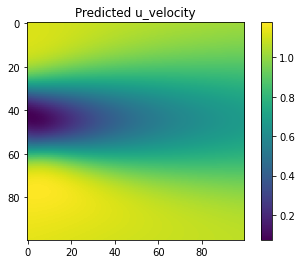

In [ ]:
uplot=np.reshape(u_pred,(100,100))
plt.imshow(uplot)
plt.title("Predicted u_velocity")
plt.colorbar()

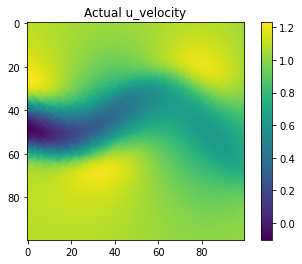

In [ ]:
upl=np.reshape(Y_star[0],(100,100))
plt.imshow(upl)
plt.title("Actual u_velocity")
plt.colorbar()